# Importing Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import itertools
import math, random
random.seed = 42


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from path import Path
import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import time

# Importing Data
in this notebook the modelnet40 has been used as the database

In [3]:
path = Path("../input/modelnet40-princeton-3d-object-dataset/ModelNet40")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'airplane': 0,
 'bathtub': 1,
 'bed': 2,
 'bench': 3,
 'bookshelf': 4,
 'bottle': 5,
 'bowl': 6,
 'car': 7,
 'chair': 8,
 'cone': 9,
 'cup': 10,
 'curtain': 11,
 'desk': 12,
 'door': 13,
 'dresser': 14,
 'flower_pot': 15,
 'glass_box': 16,
 'guitar': 17,
 'keyboard': 18,
 'lamp': 19,
 'laptop': 20,
 'mantel': 21,
 'monitor': 22,
 'night_stand': 23,
 'person': 24,
 'piano': 25,
 'plant': 26,
 'radio': 27,
 'range_hood': 28,
 'sink': 29,
 'sofa': 30,
 'stairs': 31,
 'stool': 32,
 'table': 33,
 'tent': 34,
 'toilet': 35,
 'tv_stand': 36,
 'vase': 37,
 'wardrobe': 38,
 'xbox': 39}

### Some useful functions

In [4]:
def read_off(file):
    off_header = file.readline().strip()
    if 'OFF' == off_header:
        n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    else:
        n_verts, n_faces, __ = tuple([int(s) for s in off_header[3:].split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces


def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
        layout=go.Layout(
            updatemenus=[dict(type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                        )]
                    )
                ])]
        ),
        frames=frames
    )

    return fig


def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

### Checking one of the objects in the dataset

In [5]:
with open(path/"airplane/train/airplane_0001.off", 'r') as f:
    verts, faces = read_off(f)
    
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T
len(x)

90714

In [ ]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='yellowgreen', opacity=0.50, i=i,j=j,k=k)]).show()

In [ ]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z, mode='markers')]).show()

In [ ]:
pcshow(x,y,z)

### Creating Point cloud from the mesh

In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

In [ ]:
pointcloud = PointSampler(3000)((verts, faces))
pcshow(*pointcloud.T)

In [ ]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [13]:
norm_pointcloud = Normalize()(pointcloud)
pcshow(*norm_pointcloud.T)

In [14]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [15]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)
pcshow(*noisy_rot_pointcloud.T)

In [16]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [17]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [18]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [19]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

## Preparing the data

In [20]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [21]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'airplane',
 1: 'bathtub',
 2: 'bed',
 3: 'bench',
 4: 'bookshelf',
 5: 'bottle',
 6: 'bowl',
 7: 'car',
 8: 'chair',
 9: 'cone',
 10: 'cup',
 11: 'curtain',
 12: 'desk',
 13: 'door',
 14: 'dresser',
 15: 'flower_pot',
 16: 'glass_box',
 17: 'guitar',
 18: 'keyboard',
 19: 'lamp',
 20: 'laptop',
 21: 'mantel',
 22: 'monitor',
 23: 'night_stand',
 24: 'person',
 25: 'piano',
 26: 'plant',
 27: 'radio',
 28: 'range_hood',
 29: 'sink',
 30: 'sofa',
 31: 'stairs',
 32: 'stool',
 33: 'table',
 34: 'tent',
 35: 'toilet',
 36: 'tv_stand',
 37: 'vase',
 38: 'wardrobe',
 39: 'xbox'}

In [22]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  9843
Valid dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  airplane


In [23]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [24]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 40):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [25]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [27]:
pointnet = PointNet()

optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.0008)

In [28]:
def train(model, train_loader, val_loader=None,  epochs=1):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 5 == 4:    # print every 5 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                    (epoch + 1, i + 1, len(train_loader), running_loss / 5))
                running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        torch.save(pointnet.state_dict(), "save.pth")

## Loading the pretrained model to save time

In [29]:
# Load the pretrained model weights
pointnet.load_state_dict(torch.load('/kaggle/input/pointnet-for-3d-object-classification-ii-pytorch/save.pth'))
# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pointnet.to(device)
pointnet.eval()

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

## Checking the PointNet

In [30]:
all_preds = []
all_labels = []
all_inputs = []
#all_labels2 = []

with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
        
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())
        all_inputs.append(inputs)
        #all_labels2.extend(labels.tolist()) # if labels are correct delete this code

# Concatenate all the batches into a single tensor for inputs
all_inputs = torch.cat(all_inputs, dim=0)

# Print the shapes of the accumulated inputs and the length of labels list
print(f"All Inputs Shape: {all_inputs.shape}")
print(f"All Labels Length: {len(all_labels)}")

Batch [   1 /   39]
Batch [   2 /   39]
Batch [   3 /   39]
Batch [   4 /   39]
Batch [   5 /   39]
Batch [   6 /   39]
Batch [   7 /   39]
Batch [   8 /   39]
Batch [   9 /   39]
Batch [  10 /   39]
Batch [  11 /   39]
Batch [  12 /   39]
Batch [  13 /   39]
Batch [  14 /   39]
Batch [  15 /   39]
Batch [  16 /   39]
Batch [  17 /   39]
Batch [  18 /   39]
Batch [  19 /   39]
Batch [  20 /   39]
Batch [  21 /   39]
Batch [  22 /   39]
Batch [  23 /   39]
Batch [  24 /   39]
Batch [  25 /   39]
Batch [  26 /   39]
Batch [  27 /   39]
Batch [  28 /   39]
Batch [  29 /   39]
Batch [  30 /   39]
Batch [  31 /   39]
Batch [  32 /   39]
Batch [  33 /   39]
Batch [  34 /   39]
Batch [  35 /   39]
Batch [  36 /   39]
Batch [  37 /   39]
Batch [  38 /   39]
Batch [  39 /   39]
All Inputs Shape: torch.Size([2468, 1024, 3])
All Labels Length: 2468


### Confusion Matrix

In [31]:
cm = confusion_matrix(all_labels, all_preds)
cm

array([[99,  0,  0, ...,  0,  0,  0],
       [ 0, 37,  3, ...,  0,  0,  0],
       [ 0,  1, 49, ...,  0,  0,  0],
       ...,
       [ 0,  1,  0, ..., 78,  0,  0],
       [ 0,  0,  0, ...,  1,  2,  1],
       [ 0,  0,  0, ...,  1,  0,  2]])

In [32]:
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


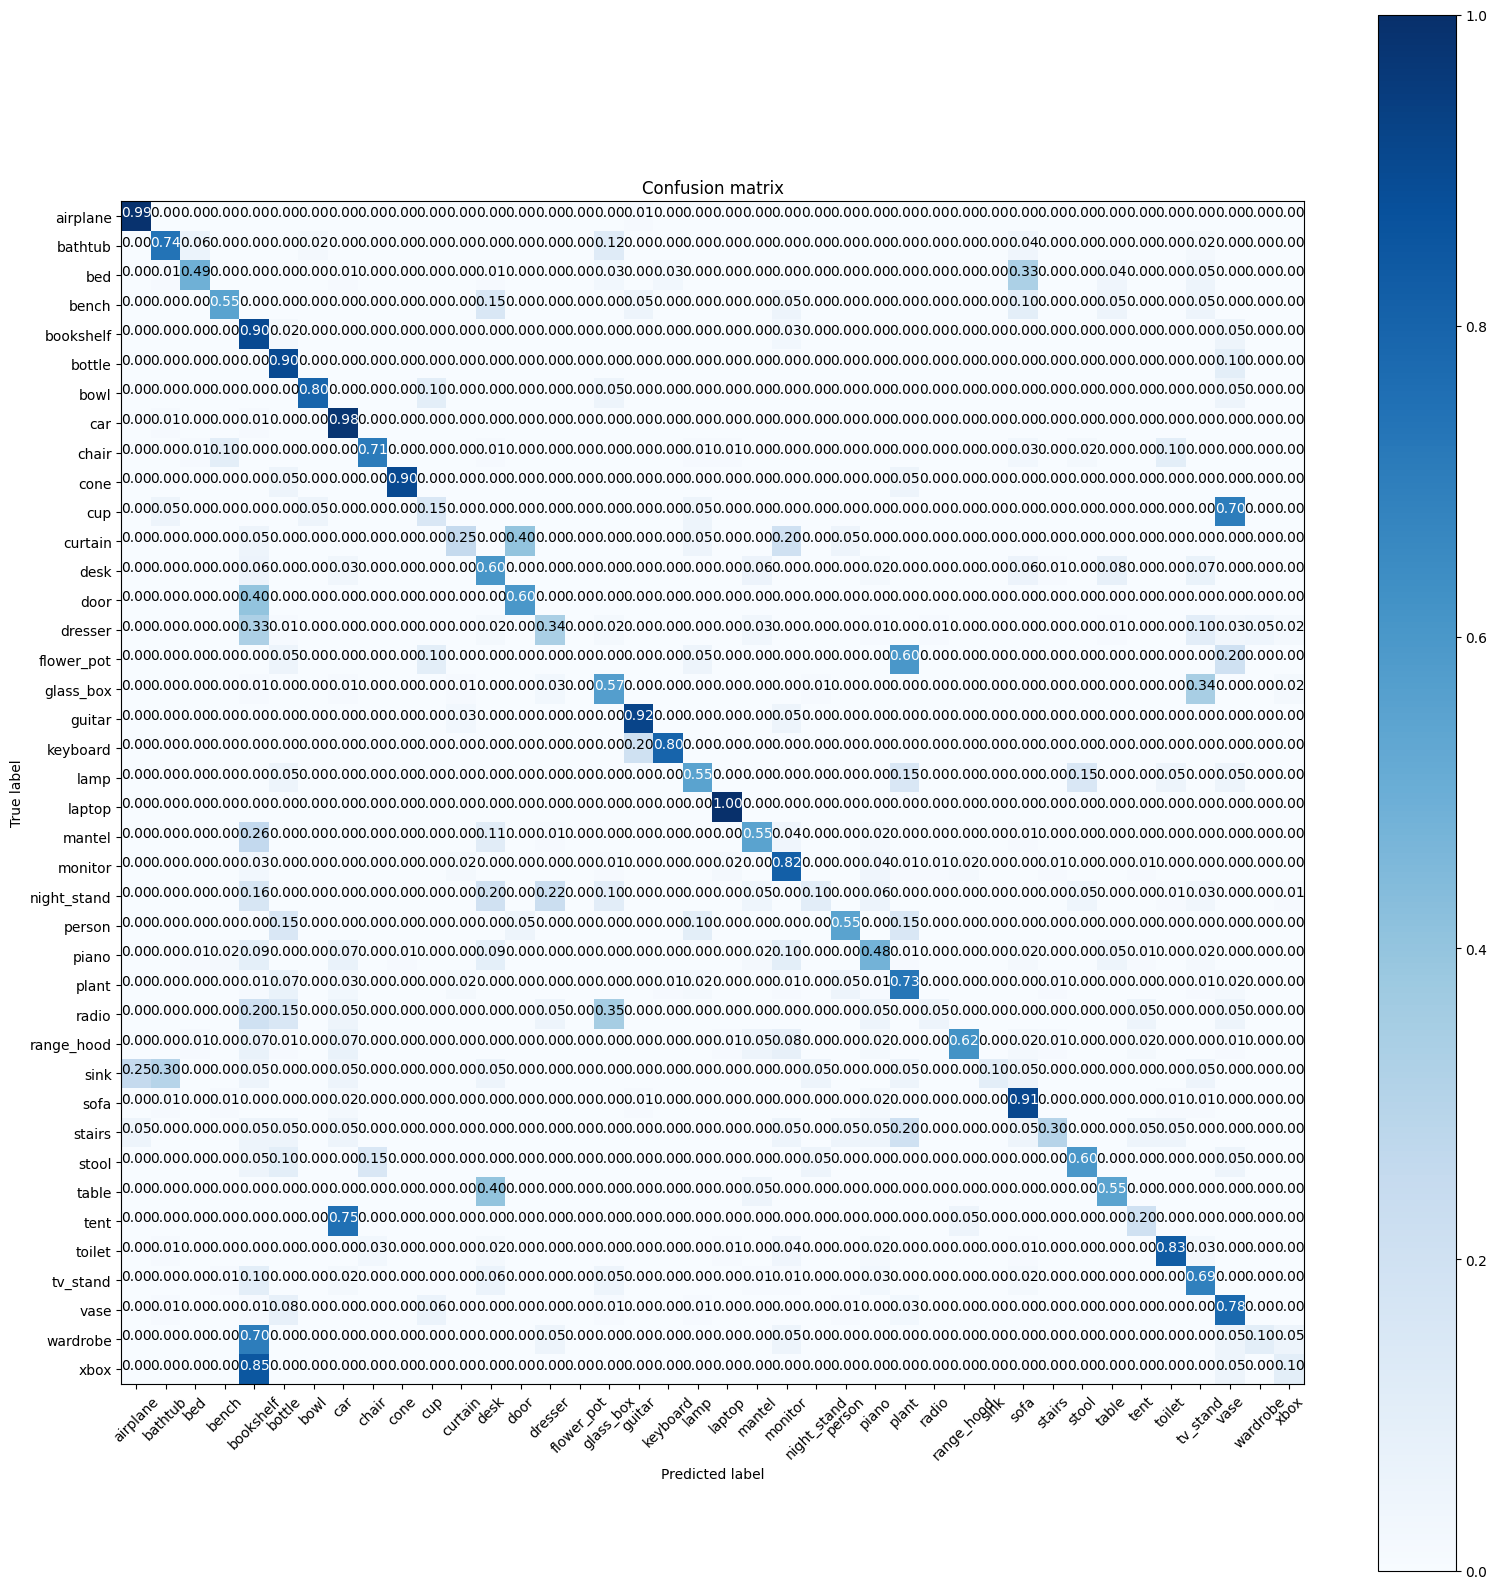

In [33]:
plt.figure(figsize=(16,16))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


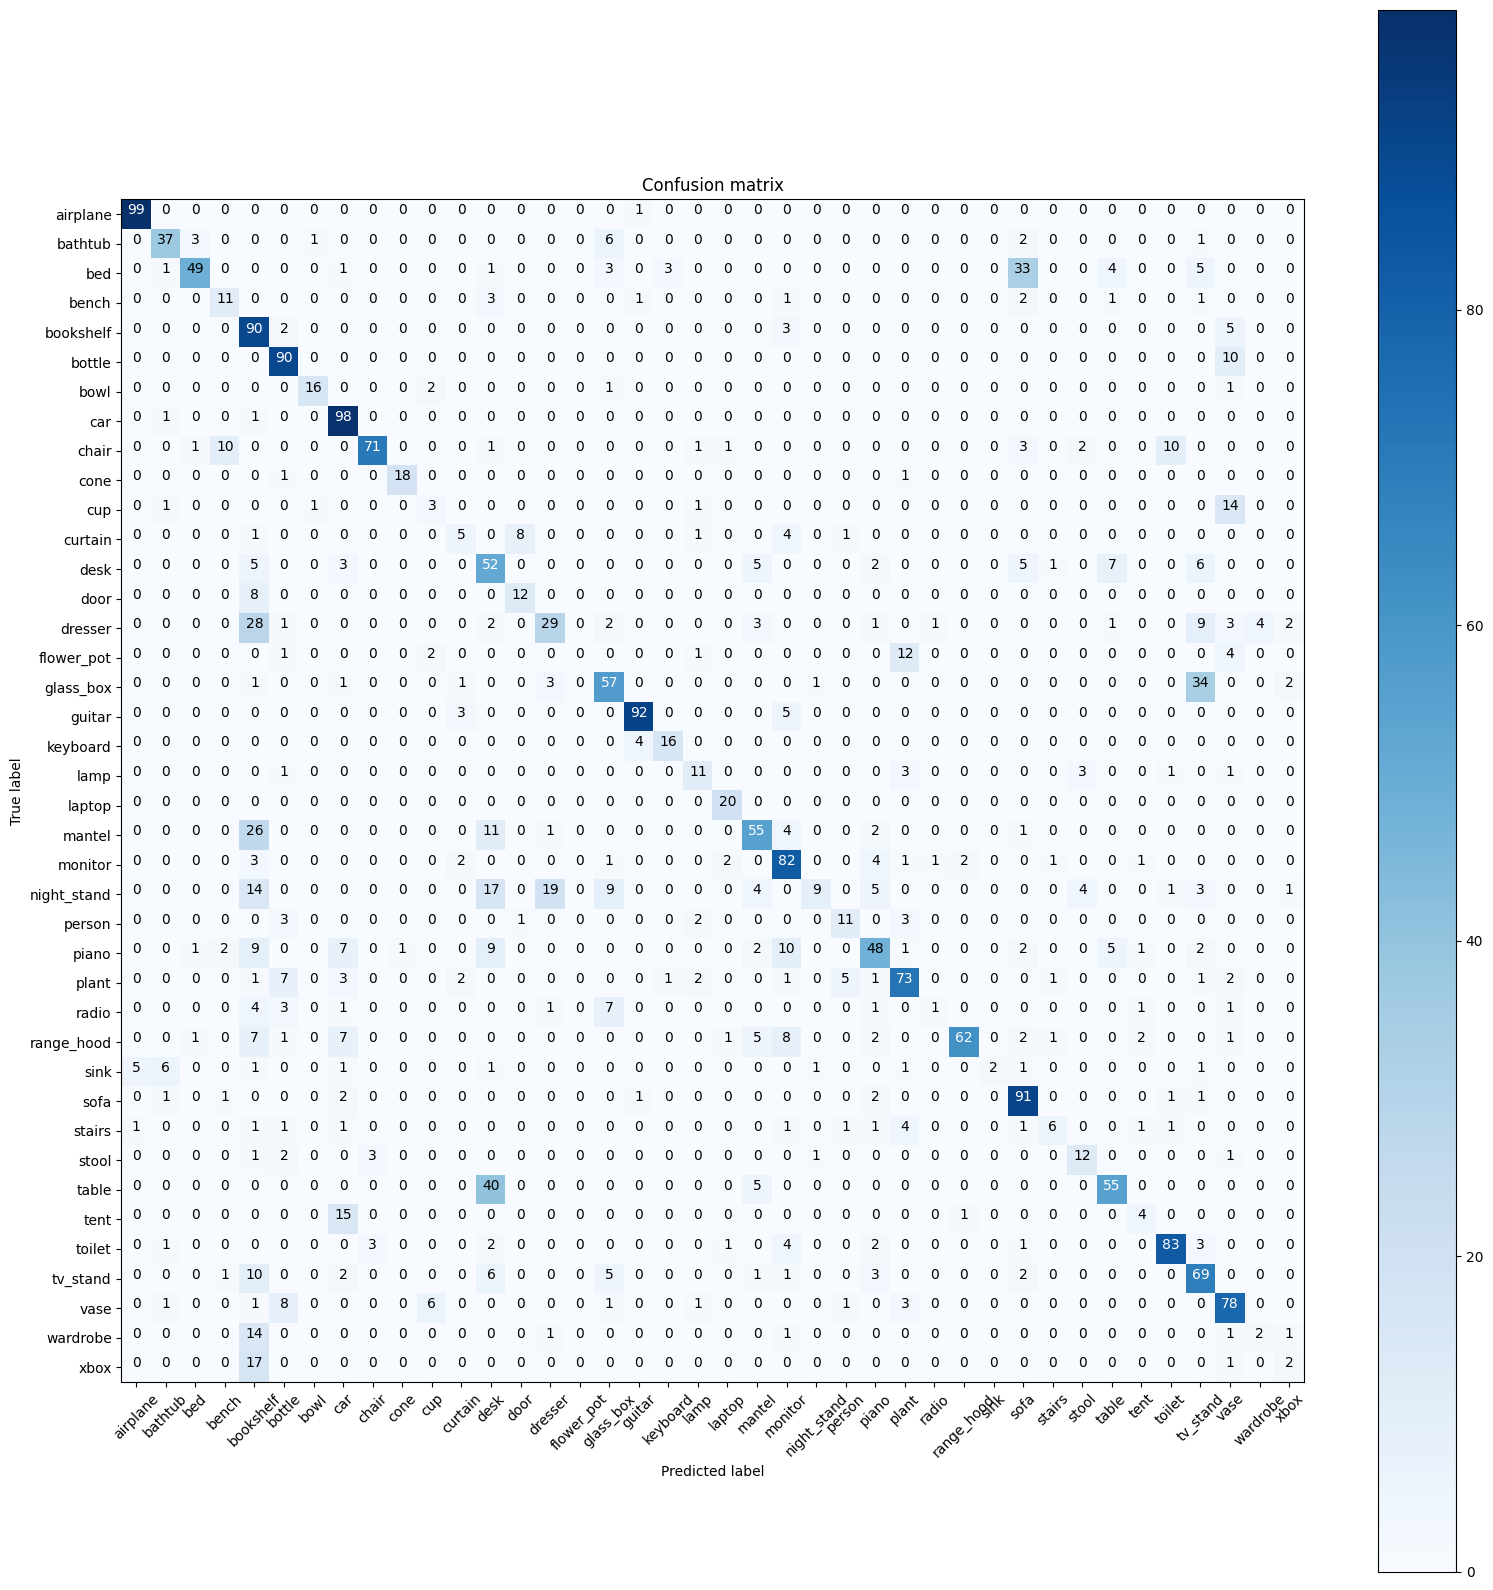

In [34]:
plt.figure(figsize=(16,16))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

# XAI

In [37]:
fidelity = []
running_time = []
all_top_features = []

random_seed = 42

In [38]:
specified_object = 1
#specified_object = 1524 #person

#person 1518 false prediction
# person 
inputs = all_inputs
labels = all_labels
print(inputs[specified_object])
print(labels[specified_object])
#pcshow(*inputs[specified_object].T)

sample_input = inputs[specified_object]
sample_label = labels[specified_object]
num_clusters = 32

tensor([[ 0.2118, -0.3166, -0.0736],
        [-0.1651, -0.0373, -0.1158],
        [ 0.0920, -0.0036, -0.0372],
        ...,
        [ 0.0631, -0.6523,  0.0120],
        [-0.0304,  0.5713,  0.1136],
        [ 0.0650, -0.8315,  0.0228]])
0


## Useful Functions

### PointNet

In [39]:
def predict_pointnet(pointnet, sample_input, sample_label):
    # Add batch dimension and convert to float
    sample_input = sample_input.unsqueeze(0).float()

    # Print the sample input and label
    #print(50*'#', 'Sample Information', 50*'#')
    #print(f"Sample Input: {sample_input}")
    #print(f"Sample Label: {sample_label}")

    # Disable gradient calculations for inference
    with torch.no_grad():
        # Pass the single sample through the model
        sample_output, _, _ = pointnet(sample_input.transpose(1, 2))
        #print(f"Sample Probability: {sample_output}")
        _, sample_pred = torch.max(sample_output.data, 1)
        
        # Print the prediction for the sample input
        #print(f"Sample Prediction: {sample_pred.item()}")

        # Get the top 5 predicted classes and their indexes
        top_values, top_indices = torch.topk(sample_output.data, 5, dim=1)
        top_pred_classes = top_indices.cpu().numpy().flatten()
        
        # Print the top 5 predicted classes
        #print(f"Top 5 Predicted Classes: {top_pred_classes}")
        
        #print(120*'#')
        return sample_pred.item(), sample_output, top_pred_classes

In [40]:
pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)

#### Clustering

In [41]:
def farthest_point_sampling(points, num_centers):

    #print(points)

    N, D = points.shape
    np.random.seed(42)
    centers = np.zeros((num_centers, D))
    center_indices = np.zeros(num_centers, dtype=int)

    center_indices[0] = np.random.randint(N)
    centers[0] = points[center_indices[0]]

    dists = np.sum((points - centers[0]) ** 2, axis=1)

    for i in range(1, num_centers):
        center_indices[i] = np.argmax(dists)
        centers[i] = points[center_indices[i]]
        new_dists = np.sum((points - centers[i]) ** 2, axis=1)
        dists = np.minimum(dists, new_dists)

    return centers

def kmeans_with_fps(points, num_clusters, max_iters):
    #print('points',points)
    if points.ndim == 3 and points.shape[0] == 1:
        points = points[0]
    
    points = points.unsqueeze(0).float()
    points = points.numpy().squeeze(0)
    centers = farthest_point_sampling(points, num_clusters)
    kmeans = KMeans(n_clusters=num_clusters, init=centers, max_iter=max_iters, n_init=1, random_state=42)
    kmeans.fit(points)
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_
    
    return cluster_centers, cluster_labels

In [42]:
cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=50)

In [43]:
len(cluster_labels)

1024

In [44]:
def pcshow_clusters(segments):
    data = []
    for i, segment in enumerate(segments):
        # Extract points from the segment
        xs, ys, zs = segment[:, 0], segment[:, 1], segment[:, 2]

        # Get a color for the current segment
        colors = plt.get_cmap("tab20")(i % 20)  # Use modulo to cycle colors if more segments than colormap
        color_str = 'rgba({}, {}, {}, 1.0)'.format(int(colors[0]*255), int(colors[1]*255), int(colors[2]*255))

        # Create a scatter plot for the current segment
        scatter = go.Scatter3d(x=xs, y=ys, z=zs, mode='markers', marker=dict(size=2, color=color_str))
        data.append(scatter)
    
    # Create a Plotly figure
    fig = go.Figure(data=data)
    
    # Show the figure
    fig.show()

In [45]:
cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=1000)

sample_numpy_array = sample_input.unsqueeze(0).float()
sample_numpy_array = sample_numpy_array.numpy().squeeze(0)

segments = []
for i in range(num_clusters):
    segments.append(sample_numpy_array[cluster_labels == i])

pcshow_clusters(segments)

## Perturbations

In [46]:
removal_probability = 0.5


def perturb_point_cloud_by_clusters(point_cloud, cluster_labels, num_perturbations, removal_probability=0.5, random_seed=None):
    """
    Applies perturbations to a point cloud by randomly removing clusters with a given probability.

    Parameters:
    point_cloud (torch.Tensor): The input point cloud of shape (num_points, 3).
    cluster_labels (np.ndarray): Cluster labels for each point in the point cloud.
    num_perturbations (int): The number of perturbations to create.
    removal_probability (float): The probability of removing each cluster.
    random_seed (int, optional): The seed for the random number generator to ensure reproducibility.

    Returns:
    tuple: A tuple containing:
        - list of torch.Tensor: A list containing perturbed point clouds.
        - list of list of int: A list containing the masks for each perturbation (0 for removed, 1 for kept).
        - list of int: A list containing the mask with all ones indicating all points are included.
        - np.ndarray: A 2D array containing the cluster masks for each perturbation.
    """
    #print('cluster labels', cluster_labels, len(cluster_labels))
    if random_seed is not None:
        np.random.seed(random_seed)

    num_points = point_cloud.size(0)
    #print('num point',num_points)
    unique_clusters = np.unique(cluster_labels)
    #print(num_clusters)
    num_clusters = len(unique_clusters)
    #print(num_clusters)
    perturbed_point_clouds = []
    masks = []
    cluster_masks = np.zeros((num_perturbations, num_clusters), dtype=int)
    iii = 0
    print(f'number of perturbations: {num_perturbations}')
    for i in range(num_perturbations):
        # Generate a mask for this perturbation using a binomial distribution for clusters
        cluster_mask = np.random.binomial(1, 1 - removal_probability, size=num_clusters)
        #print(cluster_mask, iii,i)
        #iii = iii+1
        # Create a point mask based on the cluster mask
        point_mask = np.array([cluster_mask[cluster] for cluster in cluster_labels])
        # Apply the mask to the point cloud
        indices_to_keep = [j for j, m in enumerate(point_mask) if m == 1]
        perturbed_cloud = point_cloud[indices_to_keep]

        # Add the perturbed point cloud and mask to the lists
        perturbed_point_clouds.append(perturbed_cloud)
        masks.append(point_mask)
        cluster_masks[i] = cluster_mask

    # Create a list with all ones indicating that all points are included
    all_ones_mask = [1] * num_points

    return perturbed_point_clouds, masks, all_ones_mask, cluster_masks

In [47]:
num_perturbations= 500
removal_probability = 0.5
random_seed = 42
perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)

number of perturbations: 500


In [48]:
sample_perturb = perturbed_samples[2]

# Convert to float and transpose the tensor if necessary
sample_perturb = sample_perturb.float().T  # Ensure it's a float tensor and transpose

# Visualize using pcshow
print('The main shape')
pcshow(*sample_input.T)
print('One of its perturbations')
pcshow(*sample_perturb)

The main shape


One of its perturbations


## Cosine Distances

In [49]:
from sklearn.metrics import pairwise_distances

def calculate_cosine_distances(sample_input, masks):
    # Create a reference array using the size of the sample input
    original_image_np = np.array([1] * sample_input.size(1))

    # Convert masks to a NumPy array
    masks_np = np.array(masks)
 

    # Calculate pairwise cosine distances
    distances = pairwise_distances(masks_np, [original_image_np], metric='cosine').ravel()

    # Print the distances
    #print("Cosine distances between original_image and masks:")
    #for i, dist in enumerate(distances):
        #print(f"Distance between masks[{i}] and original_image:", dist)

    return distances

## Wasserstein distances

In [50]:
from scipy.stats import wasserstein_distance

def calculate_wasserstein_distance(point_cloud1, point_cloud2):
    # Ensure the input point clouds are numpy arrays for compatibility with wasserstein_distance
    if isinstance(point_cloud1, torch.Tensor):
        point_cloud1 = point_cloud1.numpy()
    if isinstance(point_cloud2, torch.Tensor):
        point_cloud2 = point_cloud2.numpy()
    
    # Extract x, y, z coordinates
    x1, y1, z1 = point_cloud1[:, 0], point_cloud1[:, 1], point_cloud1[:, 2]
    x2, y2, z2 = point_cloud2[:, 0], point_cloud2[:, 1], point_cloud2[:, 2]
    
    # Compute Wasserstein distances for x, y, z coordinates
    wd_x = wasserstein_distance(x1, x2)
    wd_y = wasserstein_distance(y1, y2)
    wd_z = wasserstein_distance(z1, z2)
    
    # Sum the Wasserstein distances
    total_wd = wd_x + wd_y + wd_z
    
    return total_wd

## Weights

In [51]:
def calculate_weights(distances,kernel_width = 0.5):
    print('kernel_width', kernel_width)
    distances = np.array(distances)
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    #print(f"weights shape is: {weights.shape}")
    #print(weights)
    return weights

### Probabilities

In [52]:
def get_output_probabilities(pointnet, perturbed_samples):
    # Initialize a list to store the output probabilities
    output_probabilities = []

    # Disable gradient calculations for inference
    with torch.no_grad():
        for perturbed_sample in perturbed_samples:
            # Ensure the perturbed sample is a float tensor and add batch dimension
            perturbed_sample_input = perturbed_sample.unsqueeze(0).float()

            # Pass the perturbed sample through the model
            perturbed_output, _, _ = pointnet(perturbed_sample_input.transpose(1, 2))

            # Apply softmax to get probabilities
            probabilities = torch.softmax(perturbed_output, dim=1)
            
            # Append probabilities to the list
            output_probabilities.append(probabilities)

    # Convert the list of probabilities to a tensor
    output_probabilities_tensor = torch.cat(output_probabilities).view(len(perturbed_samples), 1, -1)

    # Print the shape to verify
    #print(f"Shape of output_probabilities_tensor: {output_probabilities_tensor.shape}")
    #print(output_probabilities_tensor)
    
    return output_probabilities_tensor

## Surrogate Model

In [53]:
def calculate_coefficients(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights, model_name, num_of_clusters, kernel_width,num_perturbations):
    class_to_explain = top_pred_classes[0]
    #print(f"Class to explain: {class_to_explain}")
    output_probabilities_array = output_probabilities_tensor.numpy().astype(np.float32)
    #print(f"Output probabilit {output_probabilities_array[0,0,1]}")
    perturbed_samples_np = [perturbed_sample.numpy() for perturbed_sample in perturbed_samples]
    
    simpler_model = LinearRegression()
    simpler_model.fit(X=cluster_masks, y=output_probabilities_array[:,:,class_to_explain], sample_weight=weights)
    print(cluster_masks.shape)
    coeff = simpler_model.coef_[0]
    
    # Predict using the simpler model
    y_true = output_probabilities_array[:, :, class_to_explain].ravel()
    y_pred = simpler_model.predict(cluster_masks).ravel()
    #print(f'y_true {y_true}')
    #print(f'y_pred {y_pred}')
    
    # Calculate fidelity metrics
    mse = mean_squared_error(y_true, y_pred, sample_weight=weights)
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    mae = mean_absolute_error(y_true, y_pred, sample_weight=weights)
    
    # Mean loss (Lm)
    mean_loss_f = np.mean(output_probabilities_array[:, :, class_to_explain])
    mean_loss_g = np.mean(y_pred)
    mean_loss = abs(mean_loss_f - mean_loss_g)
    
    # Mean L1 and L2 loss
    mean_l1 = np.mean(np.abs(y_true - y_pred))
    mean_l2 = np.mean((y_true - y_pred) ** 2)
    
    # Weighted L1 and L2 loss
    n = len(y_true)
    weighted_l1 = np.sum(weights * np.abs(y_true - y_pred)) / n
    weighted_l2 = np.sum(weights * (y_true - y_pred) ** 2) / n
    #print(f"weights{weights}")
    # Weighted coefficient of determination R²ω
    f_mean = np.average(y_true, weights=weights)
    ss_tot = np.sum(weights * (y_true - f_mean) ** 2)
    ss_res = np.sum(weights * (y_true - y_pred) ** 2)
    weighted_r2 = 1 - ss_res / ss_tot
    
    # Weighted adjusted coefficient of determination Rˆ²ω
    n = len(y_true)
    p = cluster_masks.shape[1]
    weighted_adj_r2 = 1 - (1 - weighted_r2) * (n - 1) / (n - p - 1)
    
    metrics = {
    "name": model_name,
    "num_clusters": num_of_clusters,
    "mse": mse,
    "r2": r2,
    "mae": mae,
    "mean_loss": mean_loss,
    "mean_l1": mean_l1,
    "mean_l2": mean_l2,
    "weighted_l1": weighted_l1,
    "weighted_l2": weighted_l2,
    "weighted_r2": weighted_r2,
    "weighted_adj_r2": weighted_adj_r2,
    'kernel_width': kernel_width,
    'perturbation': num_perturbations
    }
    
    print(100*'-')
    print('Fidelity:')
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Loss (Lm): {mean_loss}")
    print(f"Mean L1 Loss: {mean_l1}")
    print(f"Mean L2 Loss: {mean_l2}")
    print(f"Weighted L1 Loss: {weighted_l1}")
    print(f"Weighted L2 Loss: {weighted_l2}")
    print(f"Weighted R-squared (R²ω): {weighted_r2}")
    print(f"Weighted Adjusted R-squared (Rˆ²ω): {weighted_adj_r2}")
    print(100*'-')
    
    return coeff,metrics

In [54]:
def pcshowcolor(xs, ys, zs, color, name):
    return go.Scatter3d(x=xs, y=ys, z=zs,
                        mode='markers',
                        marker=dict(size=2,
                                    color=color,
                                    line=dict(width=2)),
                        name=name)

In [55]:
def Lime(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    
    sample_input = sample_input.unsqueeze(0).float()
    sample_numpy_array = sample_input.numpy().squeeze(0)

    cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=50)

    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)
    #print(cluster_masks.shape)
    #print(cluster_masks)
    distances = calculate_cosine_distances(sample_input, masks) # cosine
    weights = calculate_weights(distances,kernel_width)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)
    coeff,metrics = calculate_coefficients(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'LIME', num_clusters,kernel_width,num_perturbations)
    #print(f"coeff: {coeff}")
    fidelity.append(metrics)
    
    top_features = np.argsort(coeff)[-num_top_features:] 


    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters


    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    )

    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()
    return top_features

In [173]:
def Smile(sample_input, sample_label, pointnet, num_clusters, num_top_features, kernel_width,num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    
    cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=50)

    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)
    
    # wasserstein
    original_point_cloud = sample_input.squeeze(0)

    distances = []
    for perturbed_cloud in perturbed_samples:
        wd = calculate_wasserstein_distance(original_point_cloud, perturbed_cloud)
        distances.append(wd)

    # Print the distances
    #print("Wasserstein distances between original point cloud and perturbed point clouds:")
    #formatted_numbers = [f"{dist:.3f}" for dist in distances]
    #print(formatted_numbers)
    
    
    weights = calculate_weights(distances,kernel_width)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)

    coeff,metrics = calculate_coefficients(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'Smile-WD', num_clusters,kernel_width,num_perturbations)
    fidelity.append(metrics)
    
    top_features = np.argsort(coeff)[-num_top_features:] 


    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters

    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    # Define the layout of the plot
    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    )

    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()
    
    return top_features

In [57]:
for  kernel_width in np.arange(0.1, 0.71, 0.1):
    num_perturbations=1000
    num_top_features = round(0.2 * num_clusters)

    start_time = time.time()
    results = Lime(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'LIME',
        'time' : end_time - start_time}
    print(running_time_dict)
    running_time.append(running_time_dict)

    all_top_features.append(results)
    #print(all_top_features)

number of perturbations: 1000
kernel_width 0.1
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.011545251460751154
R-squared (R²): 0.3708545249238784
Mean Absolute Error (MAE): 0.06606868842232683
Mean Loss (Lm): 0.026490892493547524
Mean L1 Loss: 0.11436418569512424
Mean L2 Loss: 0.037139221991220946
Weighted L1 Loss: 0.002522404850515888
Weighted L2 Loss: 0.0004407806327086572
Weighted R-squared (R²ω): 0.3708545215105723
Weighted Adjusted R-squared (Rˆ²ω): 0.35003481591423136
----------------------------------------------------------------------------------------------------


{'name': 'LIME', 'time': 14.812962770462036}
number of perturbations: 1000
kernel_width 0.2
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.02308656596365844
R-squared (R²): 0.39377473889762904
Mean Absolute Error (MAE): 0.10632186064713367
Mean Loss (Lm): 0.00643159747785671
Mean L1 Loss: 0.12239230798435592
Mean L2 Loss: 0.03144583222726652
Weighted L1 Loss: 0.03750123758882806
Weighted L2 Loss: 0.0081429612879583
Weighted R-squared (R²ω): 0.3937747396547564
Weighted Adjusted R-squared (Rˆ²ω): 0.37371351077052917
----------------------------------------------------------------------------------------------------


{'name': 'LIME', 'time': 15.437548637390137}
number of perturbations: 1000
kernel_width 0.30000000000000004
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.02677824204536585
R-squared (R²): 0.4130596941593013
Mean Absolute Error (MAE): 0.11826613812523323
Mean Loss (Lm): 0.0022918950931534177
Mean L1 Loss: 0.12582174858969708
Mean L2 Loss: 0.030589548461623164
Weighted L1 Loss: 0.07241995694752558
Weighted L2 Loss: 0.01639758570625086
Weighted R-squared (R²ω): 0.4130596918755286
Weighted Adjusted R-squared (Rˆ²ω): 0.3936366413481418
----------------------------------------------------------------------------------------------------


{'name': 'LIME', 'time': 14.990877628326416}
number of perturbations: 1000
kernel_width 0.4
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.028254322015140176
R-squared (R²): 0.4222698324190973
Mean Absolute Error (MAE): 0.12296527183022486
Mean Loss (Lm): 0.0011250736906306402
Mean L1 Loss: 0.12728848453609026
Mean L2 Loss: 0.030401994630348327
Weighted L1 Loss: 0.0927662526179146
Weighted L2 Loss: 0.021315348102700214
Weighted R-squared (R²ω): 0.4222698275912322
Weighted Adjusted R-squared (Rˆ²ω): 0.4031515592178294
----------------------------------------------------------------------------------------------------


{'name': 'LIME', 'time': 15.311851978302002}
number of perturbations: 1000
kernel_width 0.5
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.028972123891614295
R-squared (R²): 0.427053472979783
Mean Absolute Error (MAE): 0.1252692472393495
Mean Loss (Lm): 0.0006642455651170165
Mean L1 Loss: 0.1280583227812948
Mean L2 Loss: 0.03034512633390727
Weighted L1 Loss: 0.10440431357547815
Weighted L2 Loss: 0.02414650661984299
Weighted R-squared (R²ω): 0.4270534707984197
Weighted Adjusted R-squared (Rˆ²ω): 0.40809350292411717
----------------------------------------------------------------------------------------------------


{'name': 'LIME', 'time': 14.861768960952759}
number of perturbations: 1000
kernel_width 0.6
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.029371300257005514
R-squared (R²): 0.4298001516260388
Mean Absolute Error (MAE): 0.12655186999498994
Mean Loss (Lm): 0.00043881642601883986
Mean L1 Loss: 0.1284972139503174
Mean L2 Loss: 0.030323623922054267
Weighted L1 Loss: 0.11143307381288935
Weighted L2 Loss: 0.02586239357544858
Weighted R-squared (R²ω): 0.4298001507478215
Weighted Adjusted R-squared (Rˆ²ω): 0.41093107610865953
----------------------------------------------------------------------------------------------------


{'name': 'LIME', 'time': 15.37843108177185}
number of perturbations: 1000
kernel_width 0.7000000000000001
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.02961513690575851
R-squared (R²): 0.4315084730171651
Mean Absolute Error (MAE): 0.12733803577812436
Mean Loss (Lm): 0.0003120818085404764
Mean L1 Loss: 0.1287708717975612
Mean L2 Loss: 0.030314134578514337
Weighted L1 Loss: 0.11593805771289792
Weighted L2 Loss: 0.02696383237556625
Weighted R-squared (R²ω): 0.4315084703349076
Weighted Adjusted R-squared (Rˆ²ω): 0.4126959274711196
----------------------------------------------------------------------------------------------------


{'name': 'LIME', 'time': 14.755878210067749}


In [58]:
for  kernel_width in np.arange(0.1, 0.72, 0.1):
    num_perturbations=1000
    num_top_features = round(0.2 * num_clusters)

    start_time = time.time()
    results = Smile(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'SMILE-WD',
        'time' : end_time - start_time}
    print(running_time_dict)
    running_time.append(running_time_dict)

    all_top_features.append(results)
    #print(all_top_features)

number of perturbations: 1000
kernel_width 0.1
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.018990361913664443
R-squared (R²): 0.3683355067866888
Mean Absolute Error (MAE): 0.09227554590764896
Mean Loss (Lm): 0.026545588112691143
Mean L1 Loss: 0.11498863231792333
Mean L2 Loss: 0.033550373736135966
Weighted L1 Loss: 0.030602010534548398
Weighted L2 Loss: 0.0062979118640865564
Weighted R-squared (R²ω): 0.3683355036378525
Weighted Adjusted R-squared (Rˆ²ω): 0.3474324386082881
----------------------------------------------------------------------------------------------------


{'name': 'SMILE-WD', 'time': 16.11739706993103}
number of perturbations: 1000
kernel_width 0.2
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.026659748636707368
R-squared (R²): 0.41371914517027275
Mean Absolute Error (MAE): 0.11813045642517515
Mean Loss (Lm): 0.008417261677166388
Mean L1 Loss: 0.12442393902661153
Mean L2 Loss: 0.030662970167026023
Weighted L1 Loss: 0.08544856900080534
Weighted L2 Loss: 0.01928408168278554
Weighted R-squared (R²ω): 0.4137191429927478
Weighted Adjusted R-squared (Rˆ²ω): 0.39431791504628233
----------------------------------------------------------------------------------------------------


{'name': 'SMILE-WD', 'time': 15.573075532913208}
number of perturbations: 1000
kernel_width 0.30000000000000004
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.028565532685924565
R-squared (R²): 0.42548990807436715
Mean Absolute Error (MAE): 0.12413864688496033
Mean Loss (Lm): 0.004004678518878979
Mean L1 Loss: 0.12702183516420845
Mean L2 Loss: 0.030388784260496113
Weighted L1 Loss: 0.10686099464641349
Weighted L2 Loss: 0.0245897737088381
Weighted R-squared (R²ω): 0.4254899088623285
Weighted Adjusted R-squared (Rˆ²ω): 0.4064781995382277
----------------------------------------------------------------------------------------------------


{'name': 'SMILE-WD', 'time': 16.017386436462402}
number of perturbations: 1000
kernel_width 0.4
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.029296771504625906
R-squared (R²): 0.4300298327355667
Mean Absolute Error (MAE): 0.12641945681056763
Mean Loss (Lm): 0.0023147161401464444
Mean L1 Loss: 0.12806431390896095
Mean L2 Loss: 0.030332354307746733
Weighted L1 Loss: 0.11604561166489506
Weighted L2 Loss: 0.026892709831488452
Weighted R-squared (R²ω): 0.43002983190147726
Weighted Adjusted R-squared (Rˆ²ω): 0.4111683578796026
----------------------------------------------------------------------------------------------------


{'name': 'SMILE-WD', 'time': 15.840987205505371}
number of perturbations: 1000
kernel_width 0.5
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.02964959222183104
R-squared (R²): 0.4322491174884219
Mean Absolute Error (MAE): 0.12752370581775516
Mean Loss (Lm): 0.0015010918693342257
Mean L1 Loss: 0.12858452235226756
Mean L2 Loss: 0.03031536888698828
Weighted L1 Loss: 0.12067391436724316
Weighted L2 Loss: 0.028056997950750905
Weighted R-squared (R²ω): 0.43224911641200114
Weighted Adjusted R-squared (Rˆ²ω): 0.41346108303576956
----------------------------------------------------------------------------------------------------


{'name': 'SMILE-WD', 'time': 16.14121103286743}
number of perturbations: 1000
kernel_width 0.6
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.029845476982234803
R-squared (R²): 0.4334943156839237
Mean Absolute Error (MAE): 0.1281328721412301
Mean Loss (Lm): 0.0010500891764788634
Mean L1 Loss: 0.12887269372262164
Mean L2 Loss: 0.030308941454847776
Weighted L1 Loss: 0.12329348646323211
Weighted L2 Loss: 0.028718258248687265
Weighted R-squared (R²ω): 0.4334943141894133
Weighted Adjusted R-squared (Rˆ²ω): 0.4147474869443887
----------------------------------------------------------------------------------------------------


{'name': 'SMILE-WD', 'time': 15.5053231716156}
number of perturbations: 1000
kernel_width 0.7000000000000001
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.029965106439504095
R-squared (R²): 0.43426047153614866
Mean Absolute Error (MAE): 0.128503399693435
Mean Loss (Lm): 0.0007749530655046799
Mean L1 Loss: 0.12904835330509207
Mean L2 Loss: 0.030306099774776357
Weighted L1 Loss: 0.12491051761175316
Weighted L2 Loss: 0.029127299079862053
Weighted R-squared (R²ω): 0.4342604679208881
Weighted Adjusted R-squared (Rˆ²ω): 0.41553899426366825
----------------------------------------------------------------------------------------------------


{'name': 'SMILE-WD', 'time': 16.01898217201233}


# SMILE-Anderson

In [ ]:
def calculate_weights2(distances,kernel_width):
    print('kernel_width',kernel_width)
    distances = np.array(distances)
    #print(distances)
    epsilon = 1e-8
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2))+ epsilon #Kernel function
    #print(weights)
    #print(f"weights shape is: {weights.shape}")
    return weights

In [ ]:
from scipy.stats import anderson

def calculate_anderson_darling_distance(original_cloud, perturbed_cloud):
    # Flatten the 3D point clouds into 1D arrays
    original_flat = original_cloud.flatten()
    perturbed_flat = perturbed_cloud.flatten()
    
    # Compute Anderson-Darling statistic
    statistic, _, _ = anderson(np.concatenate([original_flat, perturbed_flat]))
    
    return statistic

In [ ]:
def Smile_anderson(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=50)

    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)
    
    # Calculate Anderson-Darling distances
    original_point_cloud = sample_input.squeeze(0)
    distances = []
    for perturbed_cloud in perturbed_samples:
        ad_dist = calculate_anderson_darling_distance(original_point_cloud, perturbed_cloud)
        distances.append(ad_dist)

    # Print the distances
    #print("Anderson-Darling distances between original point cloud and perturbed point clouds:")
    #formatted_numbers = [f"{dist:.3f}" for dist in distances]
    #print(formatted_numbers)
    
    # Calculate weights and other necessary computations
    weights = calculate_weights2(distances,kernel_width)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)
    coeff,metrics = calculate_coefficients(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'SMILE-AD',num_clusters,kernel_width,num_perturbations)
    fidelity.append(metrics)
    top_features = np.argsort(coeff)[-num_top_features:] 

    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters

    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    )
    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()

In [ ]:
for  kernel_width in np.arange(0.1, 0.72, 0.1):
    num_perturbations=1000
    num_top_features = round(0.2 * num_clusters)

    start_time = time.time()
    results = Smile_anderson(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'SMILE-AD',
        'time' : end_time - start_time}
    print(running_time_dict)
    running_time.append(running_time_dict)

    all_top_features.append(results)
    #print(all_top_features)

# SMILE_KS

In [ ]:
from scipy.stats import ks_2samp

def calculate_ks_distance(original_cloud, perturbed_cloud):
    # Flatten the 3D point clouds into 1D arrays
    original_flat = original_cloud.flatten()
    perturbed_flat = perturbed_cloud.flatten()
    
    # Compute KS statistic
    statistic, _ = ks_2samp(original_flat, perturbed_flat)
    
    return statistic

In [ ]:
def Smile_ks(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=50)

    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)
        
    # Calculate KS distances
    original_point_cloud = sample_input.squeeze(0)
    distances = []
    for perturbed_cloud in perturbed_samples:
        ks_dist = calculate_ks_distance(original_point_cloud, perturbed_cloud)
        distances.append(ks_dist)

    # Print the distances
    #formatted_numbers = [f"{dist:.3f}" for dist in distances]
    #print(formatted_numbers)

    # Calculate weights and other necessary computations
    weights = calculate_weights(distances,kernel_width)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)
    coeff,metrics = calculate_coefficients(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'SMILE-KS',num_clusters,kernel_width,num_perturbations)
    fidelity.append(metrics)
    
    top_features = np.argsort(coeff)[-num_top_features:] 

    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters

    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    )

    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()


In [ ]:
for  kernel_width in np.arange(0.1, 0.72, 0.1):
    num_perturbations=1000
    num_top_features = round(0.2 * num_clusters)
    
    start_time = time.time()
    results = Smile_ks(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'SMILE-KS',
        'time' : end_time - start_time}
    print(running_time_dict)
    running_time.append(running_time_dict)

    all_top_features.append(results)
    #print(all_top_features)

In [ ]:
fidelity_df = pd.DataFrame(fidelity)
fidelity_df

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 2, figsize=(8, 8)) 

# Plot combining both LIME and SMILE for Mean L1
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'LIME'], x='kernel_width', y='mean_l1', ax=axs[0, 0], color='blue', label='LIME')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'Smile-WD'], x='kernel_width', y='mean_l1', ax=axs[0, 0], color='red', label='SMILE-WD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-AD'], x='kernel_width', y='mean_l1', ax=axs[0, 0], color='green', label='SMILE-AD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-KS'], x='kernel_width', y='mean_l1', ax=axs[0, 0], color='black', label='SMILE-KS')
axs[0, 0].set_ylabel('Mean L1')
axs[0, 0].set_yscale('log') 
axs[0, 0].set_xlabel('')
axs[0, 0].legend()

# Plot combining both LIME and SMILE for Mean L2
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'LIME'], x='kernel_width', y='mean_l2', ax=axs[0, 1], color='blue', label='LIME')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'Smile-WD'], x='kernel_width', y='mean_l2', ax=axs[0, 1], color='red', label='SMILE-WD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-AD'], x='kernel_width', y='mean_l2', ax=axs[0, 1], color='green', label='SMILE-AD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-KS'], x='kernel_width', y='mean_l2', ax=axs[0, 1], color='black', label='SMILE-KS')
axs[0, 1].set_ylabel('Mean L2')
axs[0, 1].set_yscale('log') 
axs[0, 1].set_xlabel('')
axs[0, 1].legend()

# Plot combining both LIME and SMILE for Weighted L1
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'LIME'], x='kernel_width', y='weighted_l1', ax=axs[1, 0], color='blue', label='LIME')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'Smile-WD'], x='kernel_width', y='weighted_l1', ax=axs[1, 0], color='red', label='SMILE-WD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-AD'], x='kernel_width', y='weighted_l1', ax=axs[1, 0], color='green', label='SMILE-AD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-KS'], x='kernel_width', y='weighted_l1', ax=axs[1, 0], color='black', label='SMILE-KS')
axs[1, 0].set_ylabel('Weighted L1')
axs[1, 0].set_xlabel('')
axs[1, 0].set_yscale('log') 

axs[1, 0].legend()

# Plot combining both LIME and SMILE for Weighted L2
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'LIME'], x='kernel_width', y='weighted_l2', ax=axs[1, 1], color='blue', label='LIME')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'Smile-WD'], x='kernel_width', y='weighted_l2', ax=axs[1, 1], color='red', label='SMILE-WD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-AD'], x='kernel_width', y='weighted_l2', ax=axs[1, 1], color='green', label='SMILE-AD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-KS'], x='kernel_width', y='weighted_l2', ax=axs[1, 1], color='black', label='SMILE-KS')
axs[1, 1].set_ylabel('Weighted L2')
axs[1, 1].set_xlabel('')
axs[1, 1].legend()
axs[1, 1].set_yscale('log') 


# Plot combining both LIME and SMILE for Mean Loss on a logarithmic scale
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'LIME'], x='kernel_width', y='mean_loss', ax=axs[2, 0], color='blue', label='LIME')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'Smile-WD'], x='kernel_width', y='mean_loss', ax=axs[2, 0], color='red', label='SMILE_WD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-AD'], x='kernel_width', y='mean_loss', ax=axs[2, 0], color='green', label='SMILE-AD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-KS'], x='kernel_width', y='mean_loss', ax=axs[2, 0], color='black', label='SMILE-KS')
axs[2, 0].set_yscale('log')  
axs[2, 0].set_ylabel('Mean Loss')
axs[2, 0].set_xlabel('Kernel Width')
axs[2, 0].legend()

# Plot combining both LIME and SMILE for Weighted Adjusted R2 Score
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'LIME'], x='kernel_width', y='weighted_adj_r2', ax=axs[2, 1], color='blue', label='LIME')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'Smile-WD'], x='kernel_width', y='weighted_adj_r2', ax=axs[2, 1], color='red', label='SMILE-WD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-AD'], x='kernel_width', y='weighted_adj_r2', ax=axs[2, 1], color='green', label='SMILE-AD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-KS'], x='kernel_width', y='weighted_adj_r2', ax=axs[2, 1], color='black', label='SMILE-KS')
axs[2, 1].set_ylabel('Adjusted R2 Score')
axs[2, 1].set_xlabel('Kernel Width')
axs[2, 1].legend()

# Adjust layout and add grid
for ax in axs.flat:
    ax.grid(True, alpha=0.2)  

plt.tight_layout()

# Save the figure
plt.savefig('/kaggle/working/kernel_width_full_comparison.svg', format='svg')

plt.show()


In [ ]:
fidelity_kernel_df = fidelity_df

# Perturbation

In [ ]:
fidelity = []
running_time = []
all_top_features = []

specified_object = 1
#specified_object = 1524 #person

#person 1518 false prediction
# person 
inputs = all_inputs
labels = all_labels
print(inputs[specified_object])
print(labels[specified_object])
#pcshow(*inputs[specified_object].T)

sample_input = inputs[specified_object]
sample_label = labels[specified_object]
num_clusters = 32

In [ ]:
for  num_perturbations in range(150, 1051, 150):
    #num_perturbations=1000
    kernel_width = 0.5
    num_top_features = round(0.2 * num_clusters)

    start_time = time.time()
    results = Lime(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'LIME',
        'time' : end_time - start_time}
    print(running_time_dict)
    running_time.append(running_time_dict)

    all_top_features.append(results)
    #print(all_top_features)

In [ ]:
for  num_perturbations in range(150, 1051, 150):
    #num_perturbations=1000
    kernel_width = 0.5
    num_top_features = round(0.2 * num_clusters)

    start_time = time.time()
    results = Smile(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'SMILE-WD',
        'time' : end_time - start_time}
    print(running_time_dict)
    running_time.append(running_time_dict)

    all_top_features.append(results)
    #print(all_top_features)

In [ ]:
for  num_perturbations in range(150, 1051, 150):
    #num_perturbations=1000
    kernel_width = 0.5
    num_top_features = round(0.2 * num_clusters)

    start_time = time.time()
    results = Smile_anderson(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'SMILE-AD',
        'time' : end_time - start_time}
    print(running_time_dict)
    running_time.append(running_time_dict)

    all_top_features.append(results)
    #print(all_top_features)

In [ ]:
for  num_perturbations in range(150, 1051, 150):
    #num_perturbations=1000
    kernel_width = 0.5
    num_top_features = round(0.2 * num_clusters)

    start_time = time.time()
    results = Smile_ks(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'SMILE-KS',
        'time' : end_time - start_time}
    print(running_time_dict)
    running_time.append(running_time_dict)

    all_top_features.append(results)
    #print(all_top_features)

In [ ]:
fidelity_df = pd.DataFrame(fidelity)
fidelity_df

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(8, 8)) 

# Plot combining both LIME and SMILE for Mean Loss
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'LIME'], x='perturbation', y='mean_l1', ax=axs[0, 0], color='blue', label='LIME')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'Smile-WD'], x='perturbation', y='mean_l1', ax=axs[0, 0], color='red', label='SMILE-WD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-AD'], x='perturbation', y='mean_l1', ax=axs[0, 0], color='green', label='SMILE-AD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-KS'], x='perturbation', y='mean_l1', ax=axs[0, 0], color='black', label='SMILE-KS')

axs[0, 0].set_yscale('log')  
#axs[0, 0].set_title('Mean L1')
axs[0, 0].set_ylabel('Mean L1')
axs[0, 0].set_xlabel('')
axs[0, 0].legend()

# Plot combining both LIME and SMILE for Weighted Adjusted R2 Score
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'LIME'], x='perturbation', y='mean_l2', ax=axs[0, 1], color='blue', label='LIME')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'Smile-WD'], x='perturbation', y='mean_l2', ax=axs[0, 1], color='red', label='SMILE_WD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-AD'], x='perturbation', y='mean_l2', ax=axs[0, 1], color='green', label='SMILE-AD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-KS'], x='perturbation', y='mean_l2', ax=axs[0, 1], color='black', label='SMILE-KS')


axs[0, 1].set_yscale('log')  

#axs[0, 1].set_title('Mean L2')
axs[0, 1].set_ylabel('Mean L2')
axs[0, 1].set_xlabel('')
axs[0, 1].legend()

# Plot combining both LIME and SMILE for Weighted L1
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'LIME'], x='perturbation', y='weighted_l1', ax=axs[1, 0], color='blue', label='LIME')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'Smile-WD'], x='perturbation', y='weighted_l1', ax=axs[1, 0], color='red', label='SMILE-WD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-AD'], x='perturbation', y='weighted_l1', ax=axs[1, 0], color='green', label='SMILE-AD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-KS'], x='perturbation', y='weighted_l1', ax=axs[1, 0], color='black', label='SMILE-KS')

axs[1, 0].set_yscale('log')  

#axs[1, 0].set_title('Weighted L1')
axs[1, 0].set_ylabel('Weighted L1')
axs[1, 0].set_xlabel('')
axs[1, 0].legend()

# Plot combining both LIME and SMILE for Weighted L2
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'LIME'], x='perturbation', y='weighted_l2', ax=axs[1, 1], color='blue', label='LIME')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'Smile-WD'], x='perturbation', y='weighted_l2', ax=axs[1, 1], color='red', label='SMILE-WD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-AD'], x='perturbation', y='weighted_l2', ax=axs[1, 1], color='green', label='SMILE-AD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-KS'], x='perturbation', y='weighted_l2', ax=axs[1, 1], color='black', label='SMILE-KS')
axs[1, 1].set_yscale('log')  


#axs[1, 1].set_title('Weighted L2')
axs[1, 1].set_ylabel('Weighted L2')
axs[1, 1].set_xlabel('')
axs[1, 1].legend()

# Plot combining both LIME and SMILE for Weighted L1
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'LIME'], x='perturbation', y='mean_loss', ax=axs[2, 0], color='blue', label='LIME')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'Smile-WD'], x='perturbation', y='mean_loss', ax=axs[2, 0], color='red', label='SMILE-WD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-AD'], x='perturbation', y='mean_loss', ax=axs[2, 0], color='green', label='SMILE-AD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-KS'], x='perturbation', y='mean_loss', ax=axs[2, 0], color='black', label='SMILE-KS')
axs[2, 0].set_yscale('log')  

#axs[2, 0].set_title('Mean Loss')
axs[2, 0].set_ylabel('Mean Loss')
axs[2, 0].set_xlabel('perturbation')
axs[2, 0].legend()

# Plot combining both LIME and SMILE for Weighted L2
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'LIME'], x='perturbation', y='weighted_adj_r2', ax=axs[2, 1], color='blue', label='LIME')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'Smile-WD'], x='perturbation', y='weighted_adj_r2', ax=axs[2, 1], color='red', label='SMILE-WD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-AD'], x='perturbation', y='weighted_adj_r2', ax=axs[2, 1], color='green', label='SMILE-AD')
sns.lineplot(data=fidelity_df[fidelity_df['name'] == 'SMILE-KS'], x='perturbation', y='weighted_adj_r2', ax=axs[2, 1], color='black', label='SMILE-KS')


#axs[2, 1].set_title('Adjusted R2 Score')
axs[2, 1].set_ylabel('Adjusted R2 Score')
axs[2, 1].set_xlabel('perturbation')
axs[2, 1].legend()

# Adjust layout and add grid
for ax in axs.flat:
    ax.grid(True, alpha=0.2)  # Apply grid settings to all subplots uniformly

plt.tight_layout()

# Save the figure
plt.savefig('/kaggle/working/perturbation_full_comparison.svg', format='svg')

plt.show()

In [ ]:
fidelity_cluster_df = fidelity_df
#fidelity_cluster_df

# Cluster

In [ ]:
fidelity = []
running_time = []
all_top_features = []

specified_object = 1
#specified_object = 1524 #person

#person 1518 false prediction
# person 
inputs = all_inputs
labels = all_labels
print(inputs[specified_object])
print(labels[specified_object])
#pcshow(*inputs[specified_object].T)

sample_input = inputs[specified_object]
sample_label = labels[specified_object]
num_clusters = 32

In [ ]:
cluster_list = [32,64,128]
for  num_clusters in cluster_list:
    num_perturbations=1000
    kernel_width = 0.5
    num_top_features = round(0.2 * num_clusters)

    start_time = time.time()
    results = Lime(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'LIME',
        'time' : end_time - start_time}
    print(running_time_dict)
    running_time.append(running_time_dict)

    all_top_features.append(results)
    #print(all_top_features)

In [ ]:
cluster_list = [32,64,128]
for  num_clusters in cluster_list:
    num_perturbations=1000
    kernel_width = 0.5
    num_top_features = round(0.2 * num_clusters)

    start_time = time.time()
    results = Smile(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'Smile',
        'time' : end_time - start_time}
    print(running_time_dict)
    running_time.append(running_time_dict)

    all_top_features.append(results)
    #print(all_top_features)

In [ ]:
cluster_list = [32,64,128]
for  num_clusters in cluster_list:
    num_perturbations=1000
    kernel_width = 0.5
    num_top_features = round(0.2 * num_clusters)

    start_time = time.time()
    results = Smile_anderson(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'SMILE-AD',
        'time' : end_time - start_time}
    print(running_time_dict)
    running_time.append(running_time_dict)

    all_top_features.append(results)
    #print(all_top_features)

In [ ]:
cluster_list = [32,64,128]
for  num_clusters in cluster_list:
    num_perturbations=1000
    kernel_width = 0.5
    num_top_features = round(0.2 * num_clusters)

    start_time = time.time()
    results = Smile_ks(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'SMILE-KS',
        'time' : end_time - start_time}
    print(running_time_dict)
    running_time.append(running_time_dict)

    all_top_features.append(results)
    #print(all_top_features)

In [ ]:
fidelity_df = pd.DataFrame(fidelity)
fidelity_df = fidelity_df.sort_values(by='num_clusters')
fidelity_df = fidelity_df[fidelity_df['num_clusters']!=1024]
fidelity_df

In [ ]:
fidelity_cluster_df = fidelity_df

In [ ]:
running_time_df = pd.DataFrame(running_time)
running_time_df['name'] =running_time_df['name'].replace('Smile', 'SMILE-WD')
running_time_df

# Bayesian Ridge

In [ ]:
fidelity = []
running_time = []
all_top_features = []
bayesian_fidelity = []
bayesian_running_time = []

specified_object = 1
#specified_object = 1524 #person

#person 1518 false prediction
# person 
inputs = all_inputs
labels = all_labels
print(inputs[specified_object])
print(labels[specified_object])
#pcshow(*inputs[specified_object].T)

sample_input = inputs[specified_object]
sample_label = labels[specified_object]
num_clusters = 32

In [ ]:
from sklearn.linear_model import BayesianRidge

def calculate_coefficients_BayesianRidge(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights, model_name, num_of_clusters, kernel_width, num_perturbations):
    class_to_explain = top_pred_classes[0]
    output_probabilities_array = output_probabilities_tensor.numpy().astype(np.float32)
    perturbed_samples_np = [perturbed_sample.numpy() for perturbed_sample in perturbed_samples]
    
    simpler_model = BayesianRidge()
    simpler_model.fit(X=cluster_masks, y=output_probabilities_array[:,:,class_to_explain].ravel(), sample_weight=weights)
    
    coeff = simpler_model.coef_
    #print(f"coeff is: {coeff}")
    
    # Predict using the simpler model
    y_true = output_probabilities_array[:, :, class_to_explain].ravel()
    y_pred = simpler_model.predict(cluster_masks).ravel()
    #print(f'y_true {y_true}')
    #print(f'y_pred {y_pred}')
    
    # Calculate fidelity metrics
    mse = mean_squared_error(y_true, y_pred, sample_weight=weights)
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    mae = mean_absolute_error(y_true, y_pred, sample_weight=weights)
    
    # Mean loss (Lm)
    mean_loss_f = np.mean(output_probabilities_array[:, :, class_to_explain])
    mean_loss_g = np.mean(y_pred)
    mean_loss = abs(mean_loss_f - mean_loss_g)
    
    # Mean L1 and L2 loss
    mean_l1 = np.mean(np.abs(y_true - y_pred))
    mean_l2 = np.mean((y_true - y_pred) ** 2)
    
    # Weighted L1 and L2 loss
    weighted_l1 = np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)
    weighted_l2 = np.sum(weights * (y_true - y_pred) ** 2) / np.sum(weights)
    #print(f"weights{weights}")
    # Weighted coefficient of determination R²ω
    f_mean = np.average(y_true, weights=weights)
    ss_tot = np.sum(weights * (y_true - f_mean) ** 2)
    ss_res = np.sum(weights * (y_true - y_pred) ** 2)
    weighted_r2 = 1 - ss_res / ss_tot
    
    # Weighted adjusted coefficient of determination Rˆ²ω
    n = len(y_true)
    p = cluster_masks.shape[1]
    weighted_adj_r2 = 1 - (1 - weighted_r2) * (n - 1) / (n - p - 1)
    
    metrics = {
    "name": model_name,
    "num_clusters": num_of_clusters,
    "mse": mse,
    "r2": r2,
    "mae": mae,
    "mean_loss": mean_loss,
    "mean_l1": mean_l1,
    "mean_l2": mean_l2,
    "weighted_l1": weighted_l1,
    "weighted_l2": weighted_l2,
    "weighted_r2": weighted_r2,
    "weighted_adj_r2": weighted_adj_r2,
    'kernel_width': kernel_width,
    'perturbation': num_perturbations
    }
    
    print(100*'-')
    print('Fidelity:')
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Loss (Lm): {mean_loss}")
    print(f"Mean L1 Loss: {mean_l1}")
    print(f"Mean L2 Loss: {mean_l2}")
    print(f"Weighted L1 Loss: {weighted_l1}")
    print(f"Weighted L2 Loss: {weighted_l2}")
    print(f"Weighted R-squared (R²ω): {weighted_r2}")
    print(f"Weighted Adjusted R-squared (Rˆ²ω): {weighted_adj_r2}")
    print(100*'-')
    
    return coeff,metrics

In [ ]:
def Lime_BayesianRidge(sample_input, sample_label, pointnet, num_clusters, num_top_features, kernel_width, num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=50)

    sample_input = sample_input.unsqueeze(0).float()
    sample_numpy_array = sample_input.numpy().squeeze(0)

    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)
    
    # wasserstein
    original_point_cloud = sample_input.squeeze(0)
    
    distances = calculate_cosine_distances(sample_input, masks) # cosine    
    weights = calculate_weights(distances)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)
    
    coeff,metrics = calculate_coefficients_BayesianRidge(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'LIME',num_clusters,  kernel_width, num_perturbations)
    bayesian_fidelity.append(metrics)
    top_features = np.argsort(coeff)[-num_top_features:] 


    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters

    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    ) 


    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()

In [ ]:
# specified_object = 1

# sample_input = all_inputs[specified_object]
# sample_label = all_labels[specified_object]
#num_clusters = 64
cluster_list = [32,64,128]
for  num_clusters in cluster_list:
    num_perturbations=1000
    num_top_features = round(0.2 * num_clusters)




    start_time = time.time()
    results = Lime_BayesianRidge(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'LIME',
        'time' : end_time - start_time}
    print(running_time_dict)
    bayesian_running_time.append(running_time_dict)



In [ ]:
def Smile_BayesianRidge(sample_input, sample_label, pointnet, num_clusters, num_top_features, kernel_width,num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    
    cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=50)

    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)
    
    # wasserstein
    original_point_cloud = sample_input.squeeze(0)

    distances = []
    for perturbed_cloud in perturbed_samples:
        wd = calculate_wasserstein_distance(original_point_cloud, perturbed_cloud)
        distances.append(wd)

    # Print the distances
    #print("Wasserstein distances between original point cloud and perturbed point clouds:")
    formatted_numbers = [f"{dist:.3f}" for dist in distances]
    #print(formatted_numbers)
    
    
    weights = calculate_weights(distances,kernel_width)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)

    coeff,metrics = calculate_coefficients_BayesianRidge(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'Smile-WD', num_clusters,kernel_width,num_perturbations)
    bayesian_fidelity.append(metrics)
    
    top_features = np.argsort(coeff)[-num_top_features:] 


    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters

    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    # Define the layout of the plot
    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    )

    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()

In [ ]:
# specified_object = 1

# sample_input = all_inputs[specified_object]
# sample_label = all_labels[specified_object]
#num_clusters = 64

cluster_list = [32,64,128]
for  num_clusters in cluster_list:
    num_perturbations=1000
    num_top_features = round(0.2 * num_clusters)




    start_time = time.time()
    results = Smile_BayesianRidge(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'SMILE-WD',
        'time' : end_time - start_time}
    print(running_time_dict)
    bayesian_running_time.append(running_time_dict)

In [ ]:
def Smile_BayesianRidge_anderson(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=50)

    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)
    
    # Calculate Anderson-Darling distances
    original_point_cloud = sample_input.squeeze(0)
    distances = []
    for perturbed_cloud in perturbed_samples:
        ad_dist = calculate_anderson_darling_distance(original_point_cloud, perturbed_cloud)
        distances.append(ad_dist)

    # Print the distances
    #print("Anderson-Darling distances between original point cloud and perturbed point clouds:")
    formatted_numbers = [f"{dist:.3f}" for dist in distances]
    #print(formatted_numbers)
    
    # Calculate weights and other necessary computations
    weights = calculate_weights2(distances,kernel_width)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)
    coeff,metrics = calculate_coefficients_BayesianRidge(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'SMILE-AD',num_clusters,kernel_width,num_perturbations)
    bayesian_fidelity.append(metrics)
    top_features = np.argsort(coeff)[-num_top_features:] 

    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters

    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    )
    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()

In [ ]:
# specified_object = 1

# sample_input = all_inputs[specified_object]
# sample_label = all_labels[specified_object]
#num_clusters = 64
cluster_list = [32,64,128]
for  num_clusters in cluster_list:
    num_perturbations=1000
    num_top_features = round(0.2 * num_clusters)




    start_time = time.time()
    results = Smile_BayesianRidge_anderson(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'SMILE-AD',
        'time' : end_time - start_time}
    print(running_time_dict)
    bayesian_running_time.append(running_time_dict)

In [ ]:
def Smile_BayesianRidge_KS(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=50)

    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)
        
    # Calculate KS distances
    original_point_cloud = sample_input.squeeze(0)
    distances = []
    for perturbed_cloud in perturbed_samples:
        ks_dist = calculate_ks_distance(original_point_cloud, perturbed_cloud)
        distances.append(ks_dist)

    # Print the distances
    formatted_numbers = [f"{dist:.3f}" for dist in distances]
    #print(formatted_numbers)

    # Calculate weights and other necessary computations
    weights = calculate_weights(distances,kernel_width)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)
    coeff,metrics = calculate_coefficients_BayesianRidge(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'SMILE-KS',num_clusters,kernel_width,num_perturbations)
    bayesian_fidelity.append(metrics)
    
    top_features = np.argsort(coeff)[-num_top_features:] 

    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters

    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    )

    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()


In [ ]:
# specified_object = 1

# sample_input = all_inputs[specified_object]
# sample_label = all_labels[specified_object]
#num_clusters = 64
cluster_list = [32,64,128]
for  num_clusters in cluster_list:
    num_perturbations=1000
    num_top_features = round(0.2 * num_clusters)




    start_time = time.time()
    results = Smile_BayesianRidge_KS(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
    end_time = time.time()


    running_time_dict = {
        'name' : 'SMILE-KS',
        'time' : end_time - start_time}
    print(running_time_dict)
    bayesian_running_time.append(running_time_dict)

In [ ]:
fidelity_bayesian_df = pd.DataFrame(bayesian_fidelity)
fidelity_bayesian_df

In [ ]:
bayesian_running_time_df = pd.DataFrame(bayesian_running_time)
bayesian_running_time_df

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = '#00008B'
ax1.set_xlabel('Model Name')
ax1.set_ylabel('Running Time (Linear Regression)', color=color)
sns.lineplot(data=running_time_df, x='name', y='time', ax=ax1, color=color, marker='o', markersize=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(14, 21)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Running Time (Bayesian Ridge)', color=color)  
sns.lineplot(data=bayesian_running_time_df, x='name', y='time', ax=ax2, color=color, marker='o', markersize=5, linestyle='dotted')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(14, 21)


fig.tight_layout()  
plt.grid(alpha=0.2)
# Save the figure in vector format (SVG)
plt.savefig('/kaggle/working/time.svg', format='svg')

# Show the plot
plt.show()

# LATENT

In [ ]:
fidelity_latent = []
running_time_latent = []

## LIME

In [ ]:
def Lime_latent(sample_input, sample_label, pointnet, num_clusters, num_top_features, kernel_width,num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=50)
    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)

    # Obtain latent space representations
    _, latent_spaces, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    
    # Calculate cosine distances based on latent spaces
    original_latent = latent_spaces.squeeze(0)
    distances = []
    
    
    for perturbed_sample in perturbed_samples:
        _, perturbed_latent, _ = predict_pointnet(pointnet, perturbed_sample, sample_label)
        perturbed_latent = perturbed_latent.squeeze(0)
        
        # Compute cosine distance using pairwise_distances
        cos_dist = pairwise_distances(perturbed_latent.reshape(1, -1), original_latent.reshape(1, -1), metric='cosine').ravel()[0]
        distances.append(cos_dist)

    # Print the distances
    #print("Cosine distances between original latent space and perturbed latent spaces:")
    formatted_numbers = [f"{dist:.3f}" for dist in distances]
    #print(formatted_numbers)
    
    # Calculate weights and other necessary computations
    weights = calculate_weights(distances)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)
    coeff,metrics = calculate_coefficients(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'LIME',num_clusters, kernel_width, num_perturbations)
    
    #print(f"coeff: {coeff}")
    
    fidelity_latent.append(metrics)
    
    top_features = np.argsort(coeff)[-num_top_features:] 

    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters

    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    )

    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()

In [ ]:
num_clusters = 32
num_perturbations=1000
num_top_features = round(0.2 * num_clusters)

kernel_width = 0.5

start_time = time.time()
results = Lime_latent(sample_input, sample_label, pointnet, num_clusters, num_top_features, kernel_width, num_perturbations)
end_time = time.time()


running_time_dict = {
    'name' : 'LIME',
    'time' : end_time - start_time}
print(running_time_dict)
running_time.append(running_time_dict)

## SMILE-WD

In [ ]:
def calculate_wasserstein_distance_latent(point_cloud1, point_cloud2):
    # Ensure the input point clouds are numpy arrays for compatibility with wasserstein_distance
    if isinstance(point_cloud1, torch.Tensor):
        point_cloud1 = point_cloud1.numpy()
    if isinstance(point_cloud2, torch.Tensor):
        point_cloud2 = point_cloud2.numpy()

    # Compute Wasserstein distance between flattened latent spaces
    wd = wasserstein_distance(point_cloud1, point_cloud2)

    return wd

In [ ]:
def Smile_latent(sample_input, sample_label, pointnet, num_clusters, num_top_features, kernel_width,num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=50)

    # Obtain latent space representations
    _, latent_spaces, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    
    # Calculate KS distances based on latent spaces
    original_latent = latent_spaces.squeeze(0)
    distances = []
    
    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)

    for perturbed_sample in perturbed_samples:
        _, perturbed_latent, _ = predict_pointnet(pointnet, perturbed_sample, sample_label)
        perturbed_latent = perturbed_latent.squeeze(0)
        
        wd = calculate_wasserstein_distance_latent(original_latent, perturbed_latent)
        distances.append(wd)

    # Print the distances
    #print("Wasserstein distances between original latent space and perturbed latent spaces:")
    #formatted_numbers = [f"{dist:.3f}" for dist in distances]
    #print(formatted_numbers)
    
    # Calculate weights and other necessary computations
    weights = calculate_weights(distances)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)

    coeff,metrics = calculate_coefficients(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'SMILE-WD',num_clusters, kernel_width,num_perturbations)
    fidelity_latent.append(metrics)
    
    top_features = np.argsort(coeff)[-num_top_features:] 

    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters

    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    )

    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()

In [ ]:
num_perturbations=1000
num_top_features = round(0.2 * num_clusters)
kernel_width = 0.5

start_time = time.time()
results = Smile_latent(sample_input, sample_label, pointnet, num_clusters, num_top_features, kernel_width,num_perturbations)
end_time = time.time()


running_time_dict = {
    'name' : 'SMILE-WD',
    'time' : end_time - start_time}
print(running_time_dict)
running_time.append(running_time_dict)

## SMILE-AD

In [ ]:
def Smile_latent_AD(sample_input, sample_label, pointnet, num_clusters, num_top_features, kernel_width, num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    
    # Obtain latent space representations
    _, latent_spaces, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    
    # Calculate KS distances based on latent spaces
    original_latent = latent_spaces.squeeze(0)
    distances = []
    
    cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=50)
    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)

    for perturbed_sample in perturbed_samples:
        _, perturbed_latent, _ = predict_pointnet(pointnet, perturbed_sample, sample_label)
        perturbed_latent = perturbed_latent.squeeze(0)
        
        ad_dist = calculate_anderson_darling_distance(perturbed_latent.reshape(1, -1), original_latent.reshape(1, -1))
        distances.append(ad_dist)

    # Print the distances
    formatted_numbers = [f"{dist:.3f}" for dist in distances]
    #print(formatted_numbers)
    
    # Calculate weights and other necessary computations
    weights = calculate_weights(distances)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)

    coeff,metrics = calculate_coefficients(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'SMILE-AD',num_clusters, kernel_width,num_perturbations)
    fidelity_latent.append(metrics)
    
    top_features = np.argsort(coeff)[-num_top_features:] 

    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters

    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    )

    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()

In [ ]:
# specified_object = 1

# sample_input = all_inputs[specified_object]
# sample_label = all_labels[specified_object]
#num_clusters = 64
num_perturbations=1000
num_top_features = round(0.2 * num_clusters)
kernel_width = 0.5


start_time = time.time()
results = Smile_latent_AD(sample_input, sample_label, pointnet, num_clusters, num_top_features, kernel_width,num_perturbations)
end_time = time.time()


running_time_dict = {
    'name' : 'SMILE-AD',
    'time' : end_time - start_time}
print(running_time_dict)
running_time.append(running_time_dict)

## SMILE-KS

In [ ]:
def Smile_latent_KS(sample_input, sample_label, pointnet, num_clusters, num_top_features, kernel_width,num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    
    # Obtain latent space representations
    _, latent_spaces, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    
    # Calculate KS distances based on latent spaces
    original_latent = latent_spaces.squeeze(0)
    distances = []
    
    cluster_centers, cluster_labels = kmeans_with_fps(sample_input, num_clusters, max_iters=50)

    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)

    for perturbed_sample in perturbed_samples:
        _, perturbed_latent, _ = predict_pointnet(pointnet, perturbed_sample, sample_label)
        perturbed_latent = perturbed_latent.squeeze(0)
        
        ks_dist = calculate_ks_distance(original_latent, perturbed_latent)
        distances.append(ks_dist)

    # Print the distances
    #print("Wasserstein distances between original latent space and perturbed latent spaces:")
    #formatted_numbers = [f"{dist:.3f}" for dist in distances]
    #print(formatted_numbers)
    
    # Calculate weights and other necessary computations
    weights = calculate_weights(distances)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)

    coeff,metrics = calculate_coefficients(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'SMILE-KS',num_clusters, kernel_width,num_perturbations)
    fidelity_latent.append(metrics)
    
    top_features = np.argsort(coeff)[-num_top_features:] 

    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters

    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    )

    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()

In [ ]:
# specified_object = 1

# sample_input = all_inputs[specified_object]
# sample_label = all_labels[specified_object]
#num_clusters = 64
num_perturbations=1000
num_top_features = round(0.2 * num_clusters)
kernel_width = 0.5

start_time = time.time()
results = Smile_latent_KS(sample_input, sample_label, pointnet, num_clusters, num_top_features, kernel_width,num_perturbations)
end_time = time.time()


running_time_dict = {
    'name' : 'SMILE_KS',
    'time' : end_time - start_time}
print(running_time_dict)
running_time.append(running_time_dict)

In [ ]:
fidelity_latent_df = pd.DataFrame(fidelity_latent)
fidelity_latent_df

In [ ]:
filtered_fidelity_df = fidelity_df[fidelity_df['num_clusters'] == 32]

# Prefix the names in fidelity_latent_df with "latent_"
fidelity_latent_df['name'] = 'Latent-' + fidelity_latent_df['name']

# Merge the dataframes
merged_df = pd.concat([filtered_fidelity_df, fidelity_latent_df], ignore_index=True)

# Display the merged dataframe
merged_df

In [ ]:
lime_df = []
smile_df = []
lime_df = merged_df[(merged_df['name'] == 'LIME')|(merged_df['name']=='Latent-LIME') ]
smile_df = merged_df[(merged_df['name'] == 'Smile-WD')|(merged_df['name']=='Latent-SMILE-WD') ]

lime_df

In [ ]:
smile_df['name'] = smile_df['name'].replace('Smile-WD', 'SMILE-WD')

smile_df

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.barplot(data = lime_df, x = 'name', y = 'weighted_adj_r2', ax=axes[0])
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Weighted Adjusted R2 Score')
#axes[0].set_title('R2 Scores of Lime')
axes[0].grid(alpha=0.2)
#axes[0].set_xticks(axes[0].get_xticks())
#axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

# Plot for Smile on the right
sns.barplot(data = smile_df, x = 'name', y = 'weighted_adj_r2', ax=axes[1])
axes[1].set_xlabel('Model')
axes[1].set_ylabel('')  
axes[1].grid(alpha=0.2)


# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('/kaggle/working/latent_bar.svg', format='svg')

plt.show()

# Stability

In [154]:
all_top_features = []

In [155]:
specified_object = 1
#specified_object = 1519 person

#person 1518 false prediction
# person 
inputs = all_inputs
labels = all_labels
print(inputs[specified_object])
print(labels[specified_object])
#pcshow(*inputs[specified_object].T)

sample_input = inputs[specified_object]
sample_label = labels[specified_object]
#num_clusters = 33

tensor([[ 0.2118, -0.3166, -0.0736],
        [-0.1651, -0.0373, -0.1158],
        [ 0.0920, -0.0036, -0.0372],
        ...,
        [ 0.0631, -0.6523,  0.0120],
        [-0.0304,  0.5713,  0.1136],
        [ 0.0650, -0.8315,  0.0228]])
0


In [156]:
# Function to generate points inside a sphere
def generate_sphere_points(center, radius, num_points):
    points = []
    for _ in range(num_points):
        u = np.random.uniform(0, 1)
        v = np.random.uniform(0, 1)
        theta = 2 * np.pi * u
        phi = np.arccos(2 * v - 1)
        r = radius * np.cbrt(np.random.uniform(0, 1))
        x = r * np.sin(phi) * np.cos(theta)
        y = r * np.sin(phi) * np.sin(theta)
        z = r * np.cos(phi)
        points.append([x + center[0], y + center[1], z + center[2]])
    return np.array(points)

# Parameters for the new points
num_new_points = 30
sphere_radius = 0.07  # Radius of the sphere

# Ensure sample_input has the correct shape
sample_input_arr = np.array(sample_input)
if sample_input_arr.ndim == 3:
    sample_input_arr = sample_input_arr.squeeze()

# Determine the bounds of the original point cloud
min_coords = sample_input_arr.min(axis=0)
max_coords = sample_input_arr.max(axis=0)

# Randomly choose the center of the sphere within the bounds
sphere_center = [np.random.uniform(min_coords[i], max_coords[i]) for i in range(3)]

# Generate new points
new_points = generate_sphere_points(sphere_center, sphere_radius, num_new_points)

# Append new points to the original point cloud
combined_point_cloud = np.vstack((sample_input_arr, new_points))

combined_point_cloud_tensor = torch.tensor(combined_point_cloud)


# Visualize the combined point cloud (assuming pcshow is a valid function)
pcshow(*combined_point_cloud.T)

combined_point_cloud = torch.tensor(combined_point_cloud)

# Reshape to add an additional dimension
combined_point_cloud = combined_point_cloud.unsqueeze(0)

In [157]:
combined_point_cloud.shape

torch.Size([1, 1054, 3])

In [158]:
# def identify_noise_cluster(original_centers, noisy_centers):
#     noise_cluster_index = None
#     min_distance_sum = float('inf')
#     for i, noisy_center in enumerate(noisy_centers):
#         distance_sum = np.sum([np.linalg.norm(noisy_center - orig_center) for orig_center in original_centers])
#         if distance_sum > min_distance_sum:
#             noise_cluster_index = i
#         else:
#             min_distance_sum = distance_sum
#     return noise_cluster_index

In [159]:
def Lime_noise(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    
    sample_input = sample_input.unsqueeze(0).float()
    sample_numpy_array = sample_input.numpy().squeeze(0)
    cluster_labels = combined_labels
    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)
    #print(cluster_masks.shape)
    #print(cluster_masks)
    distances = calculate_cosine_distances(sample_input, masks) # cosine
    weights = calculate_weights(distances,kernel_width)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)
    coeff,metrics = calculate_coefficients(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'LIME', num_clusters,kernel_width,num_perturbations)
    #print(f"coeff: {coeff}")
    fidelity.append(metrics)
    
    top_features = np.argsort(coeff)[-num_top_features:] 


    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters


    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    )

    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()
    return top_features

## LIME Stability

In [160]:
### main sample

num_perturbations=1000
num_clusters = 32

num_top_features = round(0.2 * num_clusters)
kernel_width = 0.5

print('Main Sample')
results = Lime(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
all_top_features.append(results)


Main Sample
number of perturbations: 1000
kernel_width 0.5
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.028972123891614295
R-squared (R²): 0.427053472979783
Mean Absolute Error (MAE): 0.1252692472393495
Mean Loss (Lm): 0.0006642455651170165
Mean L1 Loss: 0.1280583227812948
Mean L2 Loss: 0.03034512633390727
Weighted L1 Loss: 0.10440431357547815
Weighted L2 Loss: 0.02414650661984299
Weighted R-squared (R²ω): 0.4270534707984197
Weighted Adjusted R-squared (Rˆ²ω): 0.40809350292411717
----------------------------------------------------------------------------------------------------


In [161]:
global_seed = 42

for i in range(0, 10):
    
    np.random.seed(global_seed + i)
    # Parameters for the new points
    num_new_points = 30
    sphere_radius = 0.07  # Radius of the sphere

    # Ensure sample_input has the correct shape
    sample_input_arr = np.array(sample_input)
    if sample_input_arr.ndim == 3:
        sample_input_arr = sample_input_arr.squeeze()

    # Determine the bounds of the original point cloud
    min_coords = sample_input_arr.min(axis=0)
    max_coords = sample_input_arr.max(axis=0)

    # Randomly choose the center of the sphere within the bounds
    sphere_center = np.array([np.random.uniform(min_coords[i], max_coords[i]) for i in range(3)])

    # Generate new points
    new_points = generate_sphere_points(sphere_center, sphere_radius, num_new_points)

    # Append new points to the original point cloud
    combined_point_cloud = np.vstack((sample_input_arr, new_points))

    combined_point_cloud_tensor = torch.tensor(combined_point_cloud)

    # Visualize the combined point cloud (assuming pcshow is a valid function)
    # pcshow(*combined_point_cloud.T)

    combined_point_cloud = torch.tensor(combined_point_cloud)

    # Reshape to add an additional dimension
    combined_point_cloud = combined_point_cloud.unsqueeze(0)
    
    cluster_labels_list = cluster_labels.tolist()
    num_noise_points = len(new_points)
    new_cluster_labels = [32] * num_noise_points

    # Step 3: Combine the original labels with the new labels
    combined_labels = []
    combined_labels = cluster_labels_list + new_cluster_labels

    combined_labels = np.array(combined_labels)
    print(combined_labels)

    print('Sample with Noise')
    num_clusters = 33
    results = Lime_noise(combined_point_cloud_tensor, combined_labels, pointnet, num_clusters, num_top_features, kernel_width, num_perturbations)
    all_top_features.append(results)
    print(all_top_features)

[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.018557194558065527
R-squared (R²): 0.29653204815860335
Mean Absolute Error (MAE): 0.08589066604485207
Mean Loss (Lm): 0.0006304299629360521
Mean L1 Loss: 0.08856743566044856
Mean L2 Loss: 0.019789365455210012
Weighted L1 Loss: 0.07153438860952385
Weighted L2 Loss: 0.015455434544261102
Weighted R-squared (R²ω): 0.2965320558637089
Weighted Adjusted R-squared (Rˆ²ω): 0.2725005422441462
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3,  2, 14, 10]), array([22, 14,  3,  2, 10, 32])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.034060876728842476
R-squared (R²): 0.4824899312456763
Mean Absolute Error (MAE): 0.1434468361380288
Mean Loss (Lm): 0.0006424678566551156
Mean L1 Loss: 0.14554276360722435
Mean L2 Loss: 0.035035843726630905
Weighted L1 Loss: 0.11947027766376794
Weighted L2 Loss: 0.028367738946508504
Weighted R-squared (R²ω): 0.48248993144369257
Weighted Adjusted R-squared (Rˆ²ω): 0.4648110160582286
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3,  2, 14, 10]), array([22, 14,  3,  2, 10, 32]), array([12, 22,  3,  2, 14, 10])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.01601678184467375
R-squared (R²): 0.3006555773712484
Mean Absolute Error (MAE): 0.07775047739425357
Mean Loss (Lm): 0.0004505837079060715
Mean L1 Loss: 0.0796759489215856
Mean L2 Loss: 0.016975386663828175
Weighted L1 Loss: 0.06475479956800134
Weighted L2 Loss: 0.013339641540939357
Weighted R-squared (R²ω): 0.3006555797775836
Weighted Adjusted R-squared (Rˆ²ω): 0.27676493188178675
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3,  2, 14, 10]), array([22, 14,  3,  2, 10, 32]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.018479804827357896
R-squared (R²): 0.32980271957702234
Mean Absolute Error (MAE): 0.08739671510724885
Mean Loss (Lm): 0.0004686399699389554
Mean L1 Loss: 0.08947982925116292
Mean L2 Loss: 0.01946249898705662
Weighted L1 Loss: 0.07278870766251899
Weighted L2 Loss: 0.01539098019403013
Weighted R-squared (R²ω): 0.32980272316690873
Weighted Adjusted R-squared (Rˆ²ω): 0.3069077851384491
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3,  2, 14, 10]), array([22, 14,  3,  2, 10, 32]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.02157295964289721
R-squared (R²): 0.39716000261427176
Mean Absolute Error (MAE): 0.10156587842047365
Mean Loss (Lm): 0.0005049699123148566
Mean L1 Loss: 0.10371416613243864
Mean L2 Loss: 0.02258226870629481
Weighted L1 Loss: 0.08458955263664854
Weighted L2 Loss: 0.01796712669275054
Weighted R-squared (R²ω): 0.3971600065553008
Weighted Adjusted R-squared (Rˆ²ω): 0.37656609373576144
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3,  2, 14, 10]), array([22, 14,  3,  2, 10, 32]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10]), array([22, 12,  2,  3, 14, 10])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.016756341065493213
R-squared (R²): 0.2822997526931156
Mean Absolute Error (MAE): 0.07863503195609838
Mean Loss (Lm): 0.0005265183387012096
Mean L1 Loss: 0.08076871329801749
Mean L2 Loss: 0.017820011342051124
Weighted L1 Loss: 0.06549150441251018
Weighted L2 Loss: 0.013955586429225937
Weighted R-squared (R²ω): 0.282299758810466
Weighted Adjusted R-squared (Rˆ²ω): 0.2577820487077179
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3,  2, 14, 10]), array([22, 14,  3,  2, 10, 32]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10]), array([22, 12,  2,  3, 14, 10]), array([22,  3, 14,  2, 10, 32])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.03415952722885686
R-squared (R²): 0.44916708515721293
Mean Absolute Error (MAE): 0.14115675246073436
Mean Loss (Lm): 0.000763620861568115
Mean L1 Loss: 0.1438986434689299
Mean L2 Loss: 0.03549766019829093
Weighted L1 Loss: 0.11756297221064267
Weighted L2 Loss: 0.028449900414448077
Weighted R-squared (R²ω): 0.44916708706590447
Weighted Adjusted R-squared (Rˆ²ω): 0.4303498136426901
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3,  2, 14, 10]), array([22, 14,  3,  2, 10, 32]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10]), array([22, 12,  2,  3, 14, 10]), array([22,  3, 14,  2, 10, 32]), array([ 3, 15, 22, 14,  2, 10])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.021706240265330665
R-squared (R²): 0.26175616124763856
Mean Absolute Error (MAE): 0.09442277688011526
Mean Loss (Lm): 0.0005427126176074104
Mean L1 Loss: 0.0971245538861746
Mean L2 Loss: 0.022988066257339932
Weighted L1 Loss: 0.07864039162771592
Weighted L2 Loss: 0.018078129998212105
Weighted R-squared (R²ω): 0.26175616165670845
Weighted Adjusted R-squared (Rˆ²ω): 0.2365366516511923
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3,  2, 14, 10]), array([22, 14,  3,  2, 10, 32]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10]), array([22, 12,  2,  3, 14, 10]), array([22,  3, 14,  2, 10, 32]), array([ 3, 15, 22, 14,  2, 10]), array([32, 23, 14, 10,  3,  2])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.02713524447095202
R-squared (R²): 0.4243961623827931
Mean Absolute Error (MAE): 0.11873465253056427
Mean Loss (Lm): 0.0006008887573020205
Mean L1 Loss: 0.12136193839061368
Mean L2 Loss: 0.028347873421943455
Weighted L1 Loss: 0.09888863559519738
Weighted L2 Loss: 0.0225996981090573
Weighted R-squared (R²ω): 0.42439616564691585
Weighted Adjusted R-squared (Rˆ²ω): 0.4047326806224316
--------------------------------------------------------------------------------

[array([ 8, 22,  3,  2, 14, 10]), array([22, 14,  3,  2, 10, 32]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10]), array([22, 12,  2,  3, 14, 10]), array([22,  3, 14,  2, 10, 32]), array([ 3, 15, 22, 14,  2, 10]), array([32, 23, 14, 10,  3,  2]), array([12, 22,  3, 14,  2, 10])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.0231989935230504
R-squared (R²): 0.4036691987080815
Mean Absolute Error (MAE): 0.10758465016547668
Mean Loss (Lm): 0.0005803141184024252
Mean L1 Loss: 0.10999913195569082
Mean L2 Loss: 0.024300932771776553
Weighted L1 Loss: 0.08960231102804622
Weighted L2 Loss: 0.019321375586505644
Weighted R-squared (R²ω): 0.4036691990770428
Weighted Adjusted R-squared (Rˆ²ω): 0.3832976499771902
-----------------------------------------------

[array([ 8, 22,  3,  2, 14, 10]), array([22, 14,  3,  2, 10, 32]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10]), array([22, 12,  2,  3, 14, 10]), array([22,  3, 14,  2, 10, 32]), array([ 3, 15, 22, 14,  2, 10]), array([32, 23, 14, 10,  3,  2]), array([12, 22,  3, 14,  2, 10]), array([12, 22,  3,  2, 14, 10])]


In [162]:
main_sample_features = set(all_top_features[0])

# Initialize a list to store the Jaccard Similarities
jaccard_similarities = []

# Calculate Jaccard Similarity between main sample and each perturbed sample
for i in range(1, len(all_top_features)):
    perturbed_sample_features = set(all_top_features[i])
    intersection = len(main_sample_features.intersection(perturbed_sample_features))
    union = len(main_sample_features.union(perturbed_sample_features))
    jaccard_similarity = intersection / union
    jaccard_similarities.append(jaccard_similarity)
    print(f"Jaccard Similarity with perturbed sample {i}: {jaccard_similarity}")

# Calculate and print the mean Jaccard Similarity
mean_jaccard_similarity = np.mean(jaccard_similarities)
print(f"\nMean Jaccard Similarity over {len(jaccard_similarities)} perturbed samples: {mean_jaccard_similarity}")

Jaccard Similarity with perturbed sample 1: 0.7142857142857143
Jaccard Similarity with perturbed sample 2: 0.7142857142857143
Jaccard Similarity with perturbed sample 3: 0.5
Jaccard Similarity with perturbed sample 4: 0.5
Jaccard Similarity with perturbed sample 5: 0.7142857142857143
Jaccard Similarity with perturbed sample 6: 0.7142857142857143
Jaccard Similarity with perturbed sample 7: 0.7142857142857143
Jaccard Similarity with perturbed sample 8: 0.5
Jaccard Similarity with perturbed sample 9: 0.7142857142857143
Jaccard Similarity with perturbed sample 10: 0.7142857142857143

Mean Jaccard Similarity over 10 perturbed samples: 0.6500000000000001


## SMILE Stability

In [182]:
all_top_features_smile_wd = []

In [183]:
specified_object = 1
#specified_object = 1519 person

#person 1518 false prediction
# person 
inputs = all_inputs
labels = all_labels
print(inputs[specified_object])
print(labels[specified_object])
#pcshow(*inputs[specified_object].T)

sample_input = inputs[specified_object]
sample_label = labels[specified_object]
#num_clusters = 33

tensor([[ 0.2118, -0.3166, -0.0736],
        [-0.1651, -0.0373, -0.1158],
        [ 0.0920, -0.0036, -0.0372],
        ...,
        [ 0.0631, -0.6523,  0.0120],
        [-0.0304,  0.5713,  0.1136],
        [ 0.0650, -0.8315,  0.0228]])
0


In [184]:
def Smile_noise(sample_input, sample_label, pointnet, num_clusters, num_top_features, kernel_width,num_perturbations):
    pred, probabilities, top_pred_classes = predict_pointnet(pointnet, sample_input, sample_label)
    
    sample_input = sample_input.unsqueeze(0).float()
    sample_numpy_array = sample_input.numpy().squeeze(0)
    cluster_labels = combined_labels
    perturbed_samples, masks, all_ones_mask, cluster_masks = perturb_point_cloud_by_clusters(sample_input.squeeze(0), cluster_labels,num_perturbations, removal_probability, random_seed)
    
    # wasserstein
    original_point_cloud = sample_input.squeeze(0)

    distances = []
    for perturbed_cloud in perturbed_samples:
        wd = calculate_wasserstein_distance(original_point_cloud, perturbed_cloud)
        distances.append(wd)

    # Print the distances
    #print("Wasserstein distances between original point cloud and perturbed point clouds:")
    #formatted_numbers = [f"{dist:.3f}" for dist in distances]
    #print(formatted_numbers)
    
    
    weights = calculate_weights(distances,kernel_width)
    output_probabilities_tensor = get_output_probabilities(pointnet, perturbed_samples)

    coeff,metrics = calculate_coefficients(top_pred_classes, output_probabilities_tensor, perturbed_samples, cluster_masks, weights,'Smile-WD', num_clusters,kernel_width,num_perturbations)
    fidelity.append(metrics)
    
    top_features = np.argsort(coeff)[-num_top_features:] 


    colors = np.full(cluster_labels.shape, 'blue')  # Default color

    for cluster in top_features:
        colors[cluster_labels == cluster] = 'red'  # Color for top clusters

    data = [
        pcshowcolor(sample_numpy_array[:, 0], sample_numpy_array[:, 1], sample_numpy_array[:, 2], color=colors, name='Point Cloud')
    ]

    # Define the layout of the plot
    layout = go.Layout(
        title='',  # Remove title
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,  # Remove x-axis numbers
                showgrid=False,        # Remove x-axis grid lines
                showbackground=False   # Remove x-axis background
            ),
            yaxis=dict(
                title='',
                showticklabels=False,  # Remove y-axis numbers
                showgrid=False,        # Remove y-axis grid lines
                showbackground=False   # Remove y-axis background
            ),
            zaxis=dict(
                title='',
                showticklabels=False,  # Remove z-axis numbers
                showgrid=False,        # Remove z-axis grid lines
                showbackground=False   # Remove z-axis background
            )
        )
    )

    fig = go.Figure(data=data, layout=layout)

    # Show the plot
    fig.show()
    return top_features

In [185]:
### main sample

num_perturbations=1000
num_clusters = 32

num_top_features = round(0.2 * num_clusters)
kernel_width = 0.5

print('Main Sample')
results = Smile(sample_input, sample_label, pointnet, num_clusters, num_top_features,kernel_width,num_perturbations)
all_top_features_smile_wd.append(results)



Main Sample
number of perturbations: 1000
kernel_width 0.5
(1000, 32)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.02964959222183104
R-squared (R²): 0.4322491174884219
Mean Absolute Error (MAE): 0.12752370581775516
Mean Loss (Lm): 0.0015010918693342257
Mean L1 Loss: 0.12858452235226756
Mean L2 Loss: 0.03031536888698828
Weighted L1 Loss: 0.12067391436724316
Weighted L2 Loss: 0.028056997950750905
Weighted R-squared (R²ω): 0.43224911641200114
Weighted Adjusted R-squared (Rˆ²ω): 0.41346108303576956
----------------------------------------------------------------------------------------------------


In [186]:
all_top_features_smile_wd

[array([ 8, 22,  3, 14,  2, 10])]

In [187]:
global_seed = 42

for i in range(0, 10):
    
    np.random.seed(global_seed + i)
    # Parameters for the new points
    num_new_points = 30
    sphere_radius = 0.07  # Radius of the sphere

    # Ensure sample_input has the correct shape
    sample_input_arr = np.array(sample_input)
    if sample_input_arr.ndim == 3:
        sample_input_arr = sample_input_arr.squeeze()

    # Determine the bounds of the original point cloud
    min_coords = sample_input_arr.min(axis=0)
    max_coords = sample_input_arr.max(axis=0)

    # Randomly choose the center of the sphere within the bounds
    sphere_center = np.array([np.random.uniform(min_coords[i], max_coords[i]) for i in range(3)])

    # Generate new points
    new_points = generate_sphere_points(sphere_center, sphere_radius, num_new_points)

    # Append new points to the original point cloud
    combined_point_cloud = np.vstack((sample_input_arr, new_points))

    combined_point_cloud_tensor = torch.tensor(combined_point_cloud)

    # Visualize the combined point cloud (assuming pcshow is a valid function)
    # pcshow(*combined_point_cloud.T)

    combined_point_cloud = torch.tensor(combined_point_cloud)

    # Reshape to add an additional dimension
    combined_point_cloud = combined_point_cloud.unsqueeze(0)
    
    cluster_labels_list = cluster_labels.tolist()
    num_noise_points = len(new_points)
    new_cluster_labels = [32] * num_noise_points

    # Step 3: Combine the original labels with the new labels
    combined_labels = []
    combined_labels = cluster_labels_list + new_cluster_labels

    combined_labels = np.array(combined_labels)
    print(combined_labels)

    print('Sample with Noise')
    num_clusters = 33
    results = Smile_noise(combined_point_cloud_tensor, combined_labels, pointnet, num_clusters, num_top_features, kernel_width, num_perturbations)
    all_top_features_smile_wd.append(results)
    print(all_top_features_smile_wd)

[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.01902542978674417
R-squared (R²): 0.30261814970830225
Mean Absolute Error (MAE): 0.08792923233972313
Mean Loss (Lm): 0.0013758152447821415
Mean L1 Loss: 0.08919035876249201
Mean L2 Loss: 0.01977166573652383
Weighted L1 Loss: 0.08312095394793838
Weighted L2 Loss: 0.01798505265045143
Weighted R-squared (R²ω): 0.3026181545699954
Weighted Adjusted R-squared (Rˆ²ω): 0.27879455115468466
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3, 14,  2, 10]), array([14, 22,  3,  2, 32, 10])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.03452396510757506
R-squared (R²): 0.48822305393407284
Mean Absolute Error (MAE): 0.14522665278466368
Mean Loss (Lm): 0.0015019952278400028
Mean L1 Loss: 0.14606659910092396
Mean L2 Loss: 0.03500998085943478
Weighted L1 Loss: 0.13745947637206474
Weighted L2 Loss: 0.03267751528372245
Weighted R-squared (R²ω): 0.4882230543294245
Weighted Adjusted R-squared (Rˆ²ω): 0.47073999096800734
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3, 14,  2, 10]), array([14, 22,  3,  2, 32, 10]), array([12, 22,  3,  2, 14, 10])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.016555023842701636
R-squared (R²): 0.30670926929246956
Mean Absolute Error (MAE): 0.07984708718386564
Mean Loss (Lm): 0.0007589714804430159
Mean L1 Loss: 0.0805399188900238
Mean L2 Loss: 0.016958848839196697
Weighted L1 Loss: 0.07540876386264668
Weighted L2 Loss: 0.015634808077845962
Weighted R-squared (R²ω): 0.30670927412980353
Weighted Adjusted R-squared (Rˆ²ω): 0.2830254294572192
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3, 14,  2, 10]), array([14, 22,  3,  2, 32, 10]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.018889337600155046
R-squared (R²): 0.3357068240514526
Mean Absolute Error (MAE): 0.08909073684702805
Mean Loss (Lm): 0.0011792196867197458
Mean L1 Loss: 0.09009182653642865
Mean L2 Loss: 0.019447252728833974
Weighted L1 Loss: 0.08420160748126554
Weighted L2 Loss: 0.01785272685442407
Weighted R-squared (R²ω): 0.3357068245281102
Weighted Adjusted R-squared (Rˆ²ω): 0.3130135794032941
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3, 14,  2, 10]), array([14, 22,  3,  2, 32, 10]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.0221155979605108
R-squared (R²): 0.4022220097480196
Mean Absolute Error (MAE): 0.10345292691505946
Mean Loss (Lm): 0.0011101329010009264
Mean L1 Loss: 0.10430173286598378
Mean L2 Loss: 0.02256457953743815
Weighted L1 Loss: 0.09806085367655892
Weighted L2 Loss: 0.020962910187701654
Weighted R-squared (R²ω): 0.4022220103202109
Weighted Adjusted R-squared (Rˆ²ω): 0.38180102309512487
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3, 14,  2, 10]), array([14, 22,  3,  2, 32, 10]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10]), array([22, 12,  2,  3, 14, 10])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.017116024809151847
R-squared (R²): 0.2884934634142021
Mean Absolute Error (MAE): 0.08031258576779225
Mean Loss (Lm): 0.0012225131398131417
Mean L1 Loss: 0.08143768058162686
Mean L2 Loss: 0.017806263816118353
Weighted L1 Loss: 0.07568408514112945
Weighted L2 Loss: 0.016129609905463048
Weighted R-squared (R²ω): 0.28849346166005396
Weighted Adjusted R-squared (Rˆ²ω): 0.26418733767949676
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3, 14,  2, 10]), array([14, 22,  3,  2, 32, 10]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10]), array([22, 12,  2,  3, 14, 10]), array([22,  3, 14,  2, 10, 32])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.03471754251809738
R-squared (R²): 0.4549342458680813
Mean Absolute Error (MAE): 0.14312829796872917
Mean Loss (Lm): 0.0016924407740323
Mean L1 Loss: 0.14442575933216095
Mean L2 Loss: 0.035467119444405525
Weighted L1 Loss: 0.13488169890525686
Weighted L2 Loss: 0.03271722771187818
Weighted R-squared (R²ω): 0.4549342499380843
Weighted Adjusted R-squared (Rˆ²ω): 0.43631399139559657
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3, 14,  2, 10]), array([14, 22,  3,  2, 32, 10]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10]), array([22, 12,  2,  3, 14, 10]), array([22,  3, 14,  2, 10, 32]), array([ 3, 15, 22, 14,  2, 10])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.022432884435116804
R-squared (R²): 0.2665897266965206
Mean Absolute Error (MAE): 0.09685452511680018
Mean Loss (Lm): 0.0009246014558311755
Mean L1 Loss: 0.09780495742494898
Mean L2 Loss: 0.022971617721989215
Weighted L1 Loss: 0.09153591514421658
Weighted L2 Loss: 0.021201018781689198
Weighted R-squared (R²ω): 0.2665897282466093
Weighted Adjusted R-squared (Rˆ²ω): 0.24153534008112088
----------------------------------------------------------------------------------------------------


[array([ 8, 22,  3, 14,  2, 10]), array([14, 22,  3,  2, 32, 10]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10]), array([22, 12,  2,  3, 14, 10]), array([22,  3, 14,  2, 10, 32]), array([ 3, 15, 22, 14,  2, 10]), array([32, 23, 14, 10,  3,  2])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.02782742248941084
R-squared (R²): 0.4302849994688491
Mean Absolute Error (MAE): 0.12121844088185679
Mean Loss (Lm): 0.0012223964545908794
Mean L1 Loss: 0.12211233483122945
Mean L2 Loss: 0.02832286256315278
Weighted L1 Loss: 0.11490168054433597
Weighted L2 Loss: 0.02637732003472026
Weighted R-squared (R²ω): 0.43028500257577995
Weighted Adjusted R-squared (Rˆ²ω): 0.4108226889991762
--------------------------------------------------------------------------------

[array([ 8, 22,  3, 14,  2, 10]), array([14, 22,  3,  2, 32, 10]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10]), array([22, 12,  2,  3, 14, 10]), array([22,  3, 14,  2, 10, 32]), array([ 3, 15, 22, 14,  2, 10]), array([32, 23, 14, 10,  3,  2]), array([12, 22,  3, 14,  2, 10])]
[ 9 15 20 ... 32 32 32]
Sample with Noise
number of perturbations: 1000
kernel_width 0.5
(1000, 33)
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 0.02384580345731142
R-squared (R²): 0.4101294635362446
Mean Absolute Error (MAE): 0.10996886485924959
Mean Loss (Lm): 0.0010381589759826948
Mean L1 Loss: 0.11078393081689707
Mean L2 Loss: 0.024277741405588322
Weighted L1 Loss: 0.10397191954283283
Weighted L2 Loss: 0.022545417393105446
Weighted R-squared (R²ω): 0.4101294649821495
Weighted Adjusted R-squared (Rˆ²ω): 0.3899786081958254
----------------------------------------------

[array([ 8, 22,  3, 14,  2, 10]), array([14, 22,  3,  2, 32, 10]), array([12, 22,  3,  2, 14, 10]), array([12,  2, 14,  3, 10, 32]), array([ 2, 12, 32,  3, 14, 10]), array([22, 12,  2,  3, 14, 10]), array([22,  3, 14,  2, 10, 32]), array([ 3, 15, 22, 14,  2, 10]), array([32, 23, 14, 10,  3,  2]), array([12, 22,  3, 14,  2, 10]), array([12, 22,  3,  2, 14, 10])]


In [188]:
main_sample_features = set(all_top_features_smile_wd[0])

# Initialize a list to store the Jaccard Similarities
jaccard_similarities = []

# Calculate Jaccard Similarity between main sample and each perturbed sample
for i in range(1, len(all_top_features_smile_wd)):
    perturbed_sample_features = set(all_top_features_smile_wd[i])
    intersection = len(main_sample_features.intersection(perturbed_sample_features))
    union = len(main_sample_features.union(perturbed_sample_features))
    jaccard_similarity = intersection / union
    jaccard_similarities.append(jaccard_similarity)
    print(f"Jaccard Similarity with perturbed sample {i}: {jaccard_similarity}")

# Calculate and print the mean Jaccard Similarity
mean_jaccard_similarity = np.mean(jaccard_similarities)
print(f"\nMean Jaccard Similarity over {len(jaccard_similarities)} perturbed samples: {mean_jaccard_similarity}")

Jaccard Similarity with perturbed sample 1: 0.7142857142857143
Jaccard Similarity with perturbed sample 2: 0.7142857142857143
Jaccard Similarity with perturbed sample 3: 0.5
Jaccard Similarity with perturbed sample 4: 0.5
Jaccard Similarity with perturbed sample 5: 0.7142857142857143
Jaccard Similarity with perturbed sample 6: 0.7142857142857143
Jaccard Similarity with perturbed sample 7: 0.7142857142857143
Jaccard Similarity with perturbed sample 8: 0.5
Jaccard Similarity with perturbed sample 9: 0.7142857142857143
Jaccard Similarity with perturbed sample 10: 0.7142857142857143

Mean Jaccard Similarity over 10 perturbed samples: 0.6500000000000001


# SHAP

In [189]:
import torch
import shap

In [190]:
sample_input_tensor = torch.tensor(sample_input, dtype=torch.float32).unsqueeze(0).to(device)


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


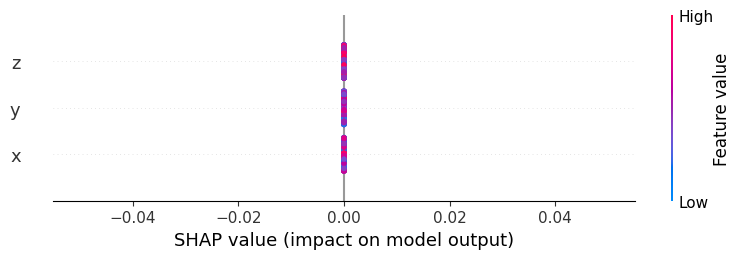

In [200]:
sample_input_tensor = torch.tensor(sample_input, dtype=torch.float32).unsqueeze(0).to(device)  # Shape (1, num_points, 3)

# Transpose to match the expected input shape of (batch_size, in_channels, num_points)
sample_input_tensor = sample_input_tensor.transpose(1, 2)  # Now shape is (1, 3, num_points)

# Prepare background data for SHAP
background = sample_input_tensor.clone().detach()

# Initialize SHAP DeepExplainer with the wrapped model
explainer = shap.DeepExplainer(wrapped_model, background)

# Compute SHAP values
shap_values = explainer.shap_values(sample_input_tensor)

# Reshape SHAP values to match the expected input format for visualization
shap_values_reshaped = shap_values[0].reshape(sample_input_tensor.shape[1], -1).T  # Shape (num_points, 3)

# Reshape features for visualization
features_reshaped = sample_input_tensor.squeeze(0).cpu().numpy().T  # Shape (num_points, 3)

# Visualization
shap.summary_plot(shap_values_reshaped, features=features_reshaped, feature_names=['x', 'y', 'z'])

In [201]:
import plotly.graph_objs as go

def pcshowcolor(xs, ys, zs, color, name='Point Cloud'):
    """
    Visualize a 3D point cloud with points colored according to importance (SHAP values).
    
    Parameters:
    - xs, ys, zs: Coordinates of the points.
    - color: Importance values (e.g., SHAP values) used to color the points.
    - name: Name of the plot.
    
    Returns:
    - A Plotly 3D scatter plot object.
    """
    return go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,
        mode='markers',
        marker=dict(
            size=4,              # Size of the points
            color=color,         # Color by SHAP values
            colorscale='Viridis',  # Color scale
            colorbar=dict(title="Importance"),
            line=dict(width=0)   # Line width of the points
        ),
        name=name
    )


In [204]:

# Extract the coordinates
xs = features_reshaped[:, 0]  # x coordinates
ys = features_reshaped[:, 1]  # y coordinates
zs = features_reshaped[:, 2]  # z coordinates

# Use the sum of SHAP values across the x, y, z dimensions to determine importance
importance = np.sum(shap_values_reshaped, axis=1)  # Summing over the x, y, z contributions

# Normalize importance for better visualization (optional)
importance_normalized = (importance - np.min(importance)) / (np.max(importance) - np.min(importance))

invalid value encountered in divide


In [203]:
min_importance = np.min(importance)
max_importance = np.max(importance)
range_importance = max_importance - min_importance

if range_importance > 0:
    importance_normalized = (importance - min_importance) / range_importance
else:
    # If range is zero, set all normalized values to 0.5 (middle of the color scale)
    importance_normalized = np.full_like(importance, 0.5)

In [207]:
import torch
import shap
import numpy as np
import plotly.graph_objs as go
import plotly.offline as pyo

# Wrapper for the PointNet model
class PointNetWrapper(torch.nn.Module):
    def __init__(self, original_model):
        super(PointNetWrapper, self).__init__()
        self.original_model = original_model
    
    def forward(self, input):
        output = self.original_model(input)
        if isinstance(output, tuple):
            return output[0]  # Assuming the first element is the prediction
        return output

# Assume the PointNet model and data are already loaded as pointnet, sample_input, etc.

# Convert to tensor and add batch dimension
sample_input_tensor = torch.tensor(sample_input, dtype=torch.float32).unsqueeze(0).to(device)  # Shape (1, num_points, 3)

# Transpose to match the expected input shape of (batch_size, in_channels, num_points)
sample_input_tensor = sample_input_tensor.transpose(1, 2)  # Now shape is (1, 3, num_points)

# Prepare background data for SHAP
background = sample_input_tensor.clone().detach()

# Initialize SHAP DeepExplainer with the wrapped model
explainer = shap.DeepExplainer(wrapped_model, background)

# Compute SHAP values
shap_values = explainer.shap_values(sample_input_tensor)

# Reshape SHAP values to match the expected input format for visualization
shap_values_reshaped = shap_values[0].reshape(sample_input_tensor.shape[1], -1).T  # Shape (num_points, 3)

# Reshape features for visualization
features_reshaped = sample_input_tensor.squeeze(0).cpu().numpy().T  # Shape (num_points, 3)

# Importance normalization with handling for division by zero
importance = np.sum(shap_values_reshaped, axis=1)  # Summing over the x, y, z contributions
min_importance = np.min(importance)
max_importance = np.max(importance)
range_importance = max_importance - min_importance

if range_importance > 0:
    importance_normalized = (importance - min_importance) / range_importance
else:
    importance_normalized = np.full_like(importance, 0.5)

# Visualization function
def pcshowcolor(xs, ys, zs, color, name='Point Cloud'):
    return go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,
        mode='markers',
        marker=dict(
            size=4,
            color=color,
            colorscale='Viridis',
            colorbar=dict(title="Importance"),
            line=dict(width=0)
        ),
        name=name
    )

# Visualize the point cloud with color indicating SHAP importance
trace = pcshowcolor(features_reshaped[:, 0], features_reshaped[:, 1], features_reshaped[:, 2], importance_normalized)

# Create the layout for the plot
layout = go.Layout(
    title='Point Cloud with SHAP Importance',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Combine the trace and layout into a figure
fig = go.Figure(data=[trace], layout=layout)

# Display the figure
pyo.iplot(fig)


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
